<a href="https://colab.research.google.com/github/itaborai83/ecd221-ML-trabalho/blob/main/ML_7_Projeto_completo_de_Classifica%C3%A7%C3%A3o_Bin%C3%A1ria_Telco_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Especialização em Ciência de Dados - PUC-Rio
# Machine Learning - Prof. Tatiana Escovedo
# Projeto completo de Classificação Binária


## 1. Definição do Problema

Este trabalho foi realizado usando o dataset sobre rotatividade de clientes encontrado no link abaixo.

https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Trata-se de um dataset de classificação  binária com o objetivo de identificar se um determinado cliente irá encerrar ou não seu plano de internet/telefonia com uma operadora.

Cada linha representa um cliente e seus atributos, incluindo informações sobre os serviços contratados, informações sobre a conta do cliente e informações demográficas sobre os clientes.




Vamos instalar as bibliotecsa **phik** para cálculo do coeficiente de correlação Phi K, capaz de lidar com variáveis numéricas e categóricas.

Da biblioteca  **mlxtend** vamos utilizar o classificador **EnsembleVoteClassifier**, pois o mesmo suporta trabalhar com classificadores já treinados (a versão do scikit learn disponibilizado no Google Colab não permite isso, sempre treinando os classificadores).

Por fim, a biblioteca **six** está sendo instalada devido a um bug no código do classificador **EnsembleVoteClassifier** que carrega essa dependência de maneira incorreta e indireta.   

In [429]:
# função de correlação que funciona com v ariáveis categóricas e numéricas
! pip install phik mlxtend

# https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
! pip install six 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [430]:
# Imports
import sys
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # transformador de colunas, usado para tratamento das variáveis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# a versão do Stacking classifier disponível no Colab não aceita classificadores pré-treinados
# from sklearn.ensemble import VotingClassifier

# correção de bug na biblioteca que importa uma dependência de maneira indireta
# https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
import six
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import EnsembleVoteClassifier

import phik
from phik.report import plot_correlation_matrix
from phik import report

# redução de dimensionalidade
from sklearn.decomposition import PCA

# para baixar os modelos já treinados
import urllib.request

from pprint import pprint, pformat

import pickle # para persistência de modelos

In [431]:
# setup ambiente

# supressão de warnings
import warnings
warnings.filterwarnings("ignore")

# exibição dos modelos como diagramas
set_config(display="diagram")

# configura pandas para exibição de apenas duas casas decimais nas variaveis
pd.set_option('display.float_format', lambda x: '%0.2f' % x)

# configura cores do Seaborn
sns.set()

In [432]:
# constantes

DATA_URL                    = f"https://raw.githubusercontent.com/itaborai83/ecd221-ML-trabalho/main/telco-churn.csv"
FIELD_SEPARATOR             = ","
IMPORT_COLUMN_NAMES         = [
    "customer_id"
,   "gender"
,   "senior_citizen"
,   "partner"
,   "dependents"
,   "tenure"
,   "phone_service"
,   "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "paperless_billing"
,   "payment_method"
,   "monthly_charges"
,   "total_charges"
,   "churn"
]
COLUMN_NAMES = [
    "gender"
,   "senior_citizen"
,   "partner"
,   "dependents"
,   "phone_service"
,   "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "paperless_billing"
,   "payment_method"
,   "tenure"
,   "monthly_charges"
,   "total_charges"
,   "churn"
]
TARGET_VARIABLE = "churn"
BOOLEAN_FEATURES = [
    "senior_citizen"
,   "partner"
,   "dependents"
,   "phone_service"
,   "paperless_billing"
]
CATEGORICAL_FEATURES = [
    "multiple_lines"
,   "internet_service"
,   "online_security"
,   "online_backup"
,   "device_protection"
,   "tech_support"
,   "streaming_tv"
,   "streaming_movies"
,   "contract"
,   "payment_method"
]
NUMERICAL_FEATURES                  = ["tenure", "monthly_charges", "total_charges"]
NUMERICAL_FEATURES_AFTER_FEAT_ENG   = ["tenure", "monthly_charges", "total_charges", "client_factor", "internet_factor", "financial_factor", "multi_factor"]
BOOLEAN_MAP                         = {"No": 0, "Yes": 1}
TEST_PCT_SIZE                       = 0.3 # 30% do conjunto de dados
RANDOM_STATE                        = 42
SCORING_METRIC                      = "recall"
K_FOLDS                             = 6
RETURN_TRAIN_SCORE                  = False
OUTPUT_TRAINING_FILE_TMPLT          = "RandomizedSearchCV_{algo}.xlsx"
QUICK_RUN                           = False
TRAIN_ALL                           = False
DOWNLOAD_ALL                        = True
DOWNLOAD_MODELS_URL                 = "https://github.com/itaborai83/ecd221-ML-trabalho/raw/main/"
FEATURE_IMPORTANCE_MODEL_FILE       = "feature_importance.pkl"
MODEL_SETTINGS                      = {
     "logreg"           : { "model_file": "logreg.pkl", "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "Regressão Logística" }
,    "knn"              : { "model_file": "knn.pkl",    "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "K-Nearest Neighbors" }
,    "nb"               : { "model_file": "nb.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "Gaussian Naive Bayes" }
,    "dt"               : { "model_file": "dt.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "Árvore de Decisão" }
,    "svm"              : { "model_file": "svm.pkl",    "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "SVM" }
,    "ada"              : { "model_file": "ada.pkl",    "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "AdaBoost" }
,    "gb"               : { "model_file": "gb.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "GradientBoosting" }
,    "rf"               : { "model_file": "rf.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "RandomForest" }
,    "vt"               : { "model_file": "vt.pkl",     "train": TRAIN_ALL, "download": DOWNLOAD_ALL, "name": "Voting Ensemble" }
}
CACHED_ANY = False in { MODEL_SETTINGS[x]["train"] for x in MODEL_SETTINGS }
RESULT_COLUMNS = ["algoritmo", "acurácia", "precisão", "recall", "F1", "ROC AUC"]
RESULTS = { }
FINAL_MODEL = "final_model.pkl"



## 2. Carga de Dados

O pacote Pandas será utilizado para carregar o conjunto de dados.

A variável target, **churn**, será convertida de **No** ou **Yes** para 0 ou 1.

O identificador do cliente, **customer_id** será eliminado, pois não ajuda no processo de classificação dos clientes.

In [433]:
# Carrega arquivo csv usando Pandas usando uma URL
churn_df = pd.read_csv(
    DATA_URL
,   names     = IMPORT_COLUMN_NAMES
,   skiprows  = 1
,   delimiter = ','
)

# transforma a variável target em uma variável numérica
churn_df["churn"] = churn_df["churn"].map(BOOLEAN_MAP)

# excluindo a variável customer_id
del churn_df["customer_id"]

any_cached = False
for algo in MODEL_SETTINGS:
  model_setting = MODEL_SETTINGS[algo]
  download      = model_setting["download"]
  model_file    = model_setting["model_file"]
  should_train  = model_setting["train"]
  if download:
    url = DOWNLOAD_MODELS_URL + model_file
    urllib.request.urlretrieve(url, model_file)
    any_cached = True
  if not should_train:
    any_cached = True
# se ao menos um modelo não for treinado, é preciso recuperar o modelo usado
# na seleção das variáveis
if any_cached:
    url = DOWNLOAD_MODELS_URL + FEATURE_IMPORTANCE_MODEL_FILE
    urllib.request.urlretrieve(url, FEATURE_IMPORTANCE_MODEL_FILE)

O dataset possui 7043 linhas, contendo cada uma 29 atributos.

In [434]:
churn_df.shape

(7043, 20)

O dataset é majoritariamente categórico, possuindo apenas as variáveis numéricas **tenure**, **monthly_charges** e **total_charges**.




In [435]:
churn_df.head()

gender  senior_citizen partner dependents  tenure phone_service  \
0  Female               0     Yes         No       1            No   
1    Male               0      No         No      34           Yes   
2    Male               0      No         No       2           Yes   
3    Male               0      No         No      45            No   
4  Female               0      No         No       2           Yes   

     multiple_lines internet_service online_security online_backup  \
0  No phone service              DSL              No           Yes   
1                No              DSL             Yes            No   
2                No              DSL             Yes           Yes   
3  No phone service              DSL             Yes            No   
4                No      Fiber optic              No            No   

  device_protection tech_support streaming_tv streaming_movies  \
0                No           No           No               No   
1               Yes           No           No               No   
2                No           No           No               No   
3               Yes          Yes           No               No   
4                No           No           No               No   

         contract paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges total_charges  churn  
0            29.85         29.85      0  
1            56.95        1889.5      0  
2            53.85        108.15      1  
3            42.30       1840.75      0  
4            70.70        151.65      1

## 3. Análise de Dados

### 3.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.

In [436]:
# Mostra as informações do dataset
print(churn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

Como mencionado, o dataset possui predominantesmente dados categóricos, representados acima como objetos com tipo de dados **object**

In [437]:
# Mostra as 10 primeiras linhas do dataset
churn_df.head(10)

gender  senior_citizen partner dependents  tenure phone_service  \
0  Female               0     Yes         No       1            No   
1    Male               0      No         No      34           Yes   
2    Male               0      No         No       2           Yes   
3    Male               0      No         No      45            No   
4  Female               0      No         No       2           Yes   
5  Female               0      No         No       8           Yes   
6    Male               0      No        Yes      22           Yes   
7  Female               0      No         No      10            No   
8  Female               0     Yes         No      28           Yes   
9    Male               0      No        Yes      62           Yes   

     multiple_lines internet_service online_security online_backup  \
0  No phone service              DSL              No           Yes   
1                No              DSL             Yes            No   
2                No              DSL             Yes           Yes   
3  No phone service              DSL             Yes            No   
4                No      Fiber optic              No            No   
5               Yes      Fiber optic              No            No   
6               Yes      Fiber optic              No           Yes   
7  No phone service              DSL             Yes            No   
8               Yes      Fiber optic              No            No   
9                No              DSL             Yes           Yes   

  device_protection tech_support streaming_tv streaming_movies  \
0                No           No           No               No   
1               Yes           No           No               No   
2                No           No           No               No   
3               Yes          Yes           No               No   
4                No           No           No               No   
5               Yes           No          Yes              Yes   
6                No           No          Yes               No   
7                No           No           No               No   
8               Yes          Yes          Yes              Yes   
9                No           No           No               No   

         contract paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   
5  Month-to-month               Yes           Electronic check   
6  Month-to-month               Yes    Credit card (automatic)   
7  Month-to-month                No               Mailed check   
8  Month-to-month               Yes           Electronic check   
9        One year                No  Bank transfer (automatic)   

   monthly_charges total_charges  churn  
0            29.85         29.85      0  
1            56.95        1889.5      0  
2            53.85        108.15      1  
3            42.30       1840.75      0  
4            70.70        151.65      1  
5            99.65         820.5      1  
6            89.10        1949.4      0  
7            29.75         301.9      0  
8           104.80       3046.05      1  
9            56.15       3487.95      0

A variável **monthly_charges** aparenta ser numérica. Ao tentar convertê-a para o tipo **float**, o seguinte erro ocorreu "*ValueError: could not convert string to float*".


In [438]:
# a conversão do tipo da coluna abaixo falha com o erro "ValueError: could not convert string to float"
# churn_df["total_charges"] = churn_df["total_charges"].astype(float)

# tenta identificar valores problemáticos
def convertible_to_float(value):
  try:
    f = float(value)
    return True
  except:
    return False
is_float = churn_df["total_charges"].map(convertible_to_float)
churn_df["total_charges_is_float"] = is_float
display(churn_df[ churn_df["total_charges_is_float"] == False ][ "total_charges" ].map(repr))

display(churn_df[ churn_df["total_charges_is_float"] == False ][ ["total_charges", "tenure", "monthly_charges"] ])


488     ' '
753     ' '
936     ' '
1082    ' '
1340    ' '
3331    ' '
3826    ' '
4380    ' '
5218    ' '
6670    ' '
6754    ' '
Name: total_charges, dtype: object

total_charges  tenure  monthly_charges
488                      0            52.55
753                      0            20.25
936                      0            80.85
1082                     0            25.75
1340                     0            56.05
3331                     0            19.85
3826                     0            25.35
4380                     0            20.00
5218                     0            19.70
6670                     0            73.35
6754                     0            61.90

O dataframe possui 11 registros com valor ' ' na coluna total_charges.

Em todos o casos, são clientes com 0 meses de prestação de serviços (variável **tenure**).

Os valores de **total_charges** serã convertidos para zero.


In [439]:
def convert_total_charges(value):
    return 0.0 if value == ' ' else value

churn_df["total_charges"] = churn_df["total_charges"].map(convert_total_charges).astype(float)
del churn_df["total_charges_is_float"]

Diferente das outras variáveis categóricas, a variável **senior_citizem** está utilizando 0's e 1's para representar verdadeiro e falso. Iremos converter estes dados momentamenteamente por questões de consistência

In [440]:
churn_df["senior_citizen"] = churn_df["senior_citizen"].map({1: "Yes", 0: "No"})

O dataset não aparenta possuir mais valores faltantes e os tipos de dados para variáveis categóricas e numéricas parecem estar corretos agora.

In [441]:
# Verifica o tipo de dataset de cada atributo
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   object 
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure             7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

In [442]:
# Faz um resumo estatístico das variáveis numéricas do dataset (média, desvio padrão, mínimo, máximo e os quartis)
churn_df.describe()

tenure  monthly_charges  total_charges   churn
count 7043.00          7043.00        7043.00 7043.00
mean    32.37            64.76        2279.73    0.27
std     24.56            30.09        2266.79    0.44
min      0.00            18.25           0.00    0.00
25%      9.00            35.50         398.55    0.00
50%     29.00            70.35        1394.55    0.00
75%     55.00            89.85        3786.60    1.00
max     72.00           118.75        8684.80    1.00

A variável **total_charges** é numericamente muito próxima das variáveis **tenure** e **monthly_charges**.

Apesar disso, a variável será mantida para não reduzir ainda mais a o número de variáveis numéricas presentes no conjunto de dados.

In [443]:
churn_df["tenure*monthly"] = churn_df["tenure"] * churn_df["monthly_charges"]
churn_df["churn"] = churn_df.pop("churn")
display(churn_df.describe())
del churn_df["tenure*monthly"]

tenure  monthly_charges  total_charges  tenure*monthly   churn
count 7043.00          7043.00        7043.00         7043.00 7043.00
mean    32.37            64.76        2279.73         2279.58    0.27
std     24.56            30.09        2266.79         2264.73    0.44
min      0.00            18.25           0.00            0.00    0.00
25%      9.00            35.50         398.55          394.00    0.00
50%     29.00            70.35        1394.55         1393.60    0.00
75%     55.00            89.85        3786.60         3786.10    1.00
max     72.00           118.75        8684.80         8550.00    1.00

Analisando os valores acimas, não conseguimos identificar valores faltantes inválidos ou outliers.

Analisando a variável target, **churn**, podemos constatar que o conjunto de dados apresenta desbalanceamento, havendo uma maior ocorrência da classe 0 (permaneceu cliente) do que a classe 1 (não permaneceu cliente).

Devido a isso, não iremos usar a métrica **acurácia** para guiar o processo de tunning dos hiperparâmetros, mas sim a métrica **área sob a curva ROC** para indicar o quão bem os diferentes modelos conseguem separar as classes da variável target. 

In [444]:
# distribuição das classes
pd.crosstab(churn_df[TARGET_VARIABLE], churn_df[TARGET_VARIABLE], normalize=True)

churn    0    1
churn          
0     0.73 0.00
1     0.00 0.27

Não está claro se o balanceamento de classes e a distribuição das variáveis do dataset correspondem à dados observados na vida real ou se algum tipo de curadoria ou rebalanceamento foi realizado (dado que a rotatividade de clientes na ordem de 27% parece ser um percentual muito elevado).

Dado o elevado número de variáveis categóricas, iremos realizar um estudo das tabulações cruzadas das variáveis categóricas com a variável target, **churn** para tentar identificar padrões possivelmetne úteis presentes no conjunto de dados.

A variável **gender** está balanceada no dataset e também balanceado quando comparada à variável target. Não está claro se essa variável é realmente útil.

In [445]:
pd.crosstab(churn_df["gender"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn     0    1  All
gender               
Female 0.36 0.13 0.50
Male   0.37 0.13 0.50
All    0.73 0.27 1.00

A variável categórica **senior_citizen** parece influenciar a rotatividade de clientes.

Se por um lado 84% dos clientes não estão na terceira idade, aproximadamente 75% (20%/27%) dos ex-clientes pertencem à esta categoria.

Por sua vez, os clientes pertencentes à terceira idade correspondem a apenas 16% dos clientes, mas desses 16%, 43% deixaram de ser clientes.

Em outras palavras. Em termos absolutos, um ex-cliente tem maior probabilidade de não pertencer a terceira idade. Em contra-partida, dado que um cliente pertence à terceira idade, ele tem maior probabilidade de se tornar um ex-cliente.




In [446]:
pd.crosstab(churn_df["senior_citizen"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn             0    1  All
senior_citizen               
No             0.64 0.20 0.84
Yes            0.09 0.07 0.16
All            0.73 0.27 1.00

A variável **partner**, que indica se um cliente possui ou não algum tipo de parceiro/cônjuge parece estar bem distribuída no conjunto de dados com aproximadamente metade dos clientes tendo algum parceiro e a outra metade não.

Entretanto, podemos que observar que a retenção dos clientes tende a ser pior entre os clientes que não possuem algum tipo de parceiro, pois aproximadamente 2/3 dos ex-clientes enquadram-se nessa situação

In [447]:
pd.crosstab(churn_df["partner"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn      0    1  All
partner               
No      0.35 0.17 0.52
Yes     0.39 0.09 0.48
All     0.73 0.27 1.00

A variável **dependents**, que indica se um cliente possui ou não algum tipo de dependente parece ser um forte indicador sobre a rotatividade dos clientes pois mais de 81% (22%/27%) dos ex-clientes não possuem dependentes.

In [448]:
pd.crosstab(churn_df["dependents"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn         0    1  All
dependents               
No         0.48 0.22 0.70
Yes        0.25 0.05 0.30
All        0.73 0.27 1.00

A variável **tenure**, que representa o número de meses em que um cliente possui algum tipo de relacionamento comercial com a empresa, parece indicar que a empresa oferece planos/contratos de duração máxima de 72 meses (ou que clientes com mais do que 72 meses são agrupados nessa categoria)

Analisando os clientes que permaneceram com a empresa, podemos obseravar uma distribuição em forma de U, onde um número sigificativo de clientes possuem poucos meses de relacionamento e um número ainda maior parece estar se aproximando do teto de 72 meses.

Por sua vez, a análise dos futuros ex-clientes indicam que a maioria parece cancelar seus serviços nos primeiros meses de relacionamento com a empresa e, passado o tempo, fidelizam-se.

Estas distribuições parecem indicar a necessidade de que medidas de fidelização sejam tomadas nos críticos primeiros meses.

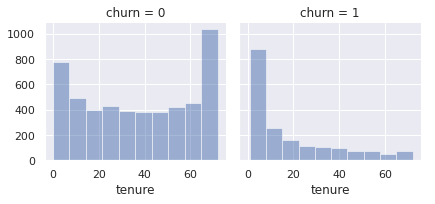

In [449]:
g = sns.FacetGrid(churn_df, col="churn", size=3)
g.map_dataframe(plt.hist, x="tenure", alpha=0.5)
g.add_legend();

A variável **phone_service** está desbalanceada e o fato de um usuário não possuir nenhum tipo de serviço telefônico contratado parece não ser expressivo em termos absolutos ou relativos

In [450]:
pd.crosstab(churn_df["phone_service"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn            0    1  All
phone_service               
No            0.07 0.02 0.10
Yes           0.66 0.24 0.90
All           0.73 0.27 1.00

A variável **multiple_lines** parece não informações significativas para determinar a rotatividade dos clientes

In [451]:
pd.crosstab(churn_df["multiple_lines"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn               0    1  All
multiple_lines                 
No               0.36 0.12 0.48
No phone service 0.07 0.02 0.10
Yes              0.30 0.12 0.42
All              0.73 0.27 1.00

A variável **internet_service** usada para identificar qual o tipo de fornecimento de internet o usuário possui (ou não) indica que quase 2/3 entre todos os ex-clientes parecem ter contratado internet por fibra ótica.

Isso parece indicar a existência de problemas na qualidade do fornecimento do serviço ou na precificação do mesmo.

In [452]:
pd.crosstab(churn_df["internet_service"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn               0    1  All
internet_service               
DSL              0.28 0.07 0.34
Fiber optic      0.26 0.18 0.44
No               0.20 0.02 0.22
All              0.73 0.27 1.00

O serviço de fibra ótica, conforme esperado, parece contribuir com o aumento dos custos mensais dos clientes e consequentemente afetando negativamente na retenção dos clientes que contrataram esse serviço.

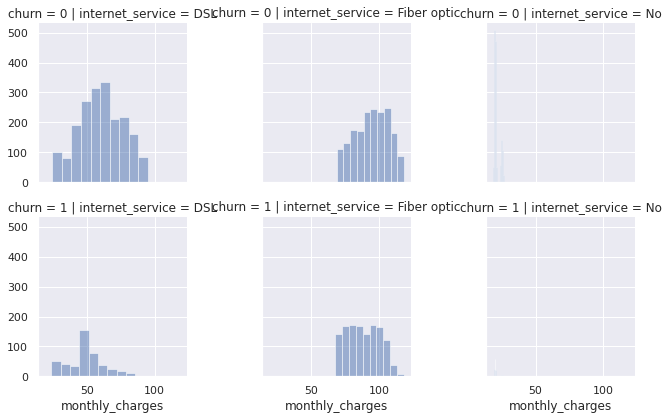

In [453]:
g = sns.FacetGrid(churn_df, col="internet_service", row="churn", size=3)
g.map_dataframe(plt.hist, x="monthly_charges", alpha=0.5)
g.add_legend();

Análise da variável **total_charges** nos revela, como já esperado, que os clientes novos que contrataram a internet mais cara(fibra ótica), tem a maior probabilidade de cancelarem os seus serviços.

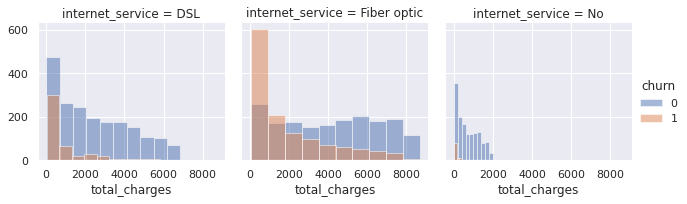

In [454]:
g = sns.FacetGrid(churn_df, col="internet_service", hue="churn", size=3)
g.map_dataframe(plt.hist, x="total_charges", alpha=0.5)
g.add_legend();

As variáveis **online_security**, **online_backup**, **device_protection** e **tech_support** comportam-se de maneira parecida. Em todos os casos, a não contratação dos serviços parecem aumentar a probabilidade do cliente desfazer seu relacionamento com a empresa.

Em outras palavras, a contratação desses serviços parece ser indicativo de que um cliente está fidelizado.


In [455]:
pd.crosstab(churn_df["online_security"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn                  0    1  All
online_security                   
No                  0.29 0.21 0.50
No internet service 0.20 0.02 0.22
Yes                 0.24 0.04 0.29
All                 0.73 0.27 1.00

In [456]:
pd.crosstab(churn_df["online_backup"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn                  0    1  All
online_backup                     
No                  0.26 0.18 0.44
No internet service 0.20 0.02 0.22
Yes                 0.27 0.07 0.34
All                 0.73 0.27 1.00

In [457]:
pd.crosstab(churn_df["device_protection"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn                  0    1  All
device_protection                 
No                  0.27 0.17 0.44
No internet service 0.20 0.02 0.22
Yes                 0.27 0.08 0.34
All                 0.73 0.27 1.00

In [458]:
pd.crosstab(churn_df["tech_support"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn                  0    1  All
tech_support                      
No                  0.29 0.21 0.49
No internet service 0.20 0.02 0.22
Yes                 0.25 0.04 0.29
All                 0.73 0.27 1.00

As variáveis **streaming_movies** e **streaming_tv** parecem não influenciar de forma significativa a rotatividade dos clientes, possivelmente por se tratarem de serviços de uso muito prevalente.

In [459]:
pd.crosstab(churn_df["streaming_tv"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn                  0    1  All
streaming_tv                      
No                  0.27 0.13 0.40
No internet service 0.20 0.02 0.22
Yes                 0.27 0.12 0.38
All                 0.73 0.27 1.00

In [460]:
pd.crosstab(churn_df["streaming_movies"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn                  0    1  All
streaming_movies                  
No                  0.26 0.13 0.40
No internet service 0.20 0.02 0.22
Yes                 0.27 0.12 0.39
All                 0.73 0.27 1.00

Aproximadamente 85% da rotatividade dos clientes ocorrem entre aqueles que possuem contratos mensais, aparentando-ser um dos principais fatores que contribuem com a rotatividade dos clientes.

Os clientes tendem a permanecer fidelizados pela duração do contrato vigente que assinaram com a empresa de telefonia/telecomunicações.

In [461]:
pd.crosstab(churn_df["contract"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn             0    1  All
contract                     
Month-to-month 0.32 0.23 0.55
One year       0.19 0.02 0.21
Two year       0.23 0.01 0.24
All            0.73 0.27 1.00

Clientes que possuem cobrança digital tendem a ter uma rotatividade mais alta do que clientes cobrados de maneira impressa.

In [462]:
pd.crosstab(churn_df["paperless_billing"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn                0    1  All
paperless_billing               
No                0.34 0.07 0.41
Yes               0.39 0.20 0.59
All               0.73 0.27 1.00

os métodos de pagamento presentes no dataset estão todos balanceados quando compara-se os cliente que permaneceram contratando os serviços da empresa.

Entre os ex-clientes, a probabilidade de que o método de pagamento empregado tenha sido cheques eletrônicos (depósitos automáticos) é consideravelmente maior, conforme dados acima.

In [463]:
pd.crosstab(churn_df["payment_method"], churn_df[TARGET_VARIABLE], normalize=True, margins=True)

churn                        0    1  All
payment_method                          
Bank transfer (automatic) 0.18 0.04 0.22
Credit card (automatic)   0.18 0.03 0.22
Electronic check          0.18 0.15 0.34
Mailed check              0.19 0.04 0.23
All                       0.73 0.27 1.00

Conforme analisada realizada anteriormente, a variável **monthly_charges** parece ter uma significativa correlação positiva com a rotatividade dos clientes. 

Foi observado que o serviço contratado de internet de fibra ótica parece ser, dentre os serviços existentes, aquele que mais contribui com o aumento do valor mensal cobrado e que, consequentemente, mais influencia na rotatividade.

Ademais, os dados dos ex-clientes parecem indicar a existência de uma distribuição tri-modal composta primeiramente pelos clientes que utilizam-se apenas dos serviços de telefonia, subsequentemente, os clientes que utilizam-se da internet via DSL e, por último, os clientes que se utilizam da internet via fibra ótica.

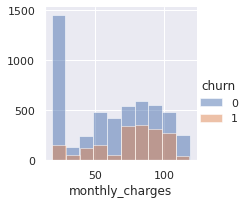

In [464]:
g = sns.FacetGrid(churn_df, hue="churn", size=3)
g.map_dataframe(plt.hist, x="monthly_charges", alpha=0.5)
g.add_legend();

Com base nas análises acima, as seguintes ações serão tomadas

*   Variável **gender** será eliminada;
*   As variáveis categóricas serão posteriormente tratadas.



In [465]:
del churn_df["gender"]
# reposicionando a variável target no final
churn_df["churn"] = churn_df.pop("churn")


### 3.2. Visualizações Unimodais Dados Numéricos

Vamos criar agora um histograma para cada atributo do dataset.

Os histogramas não indicam a presença de outliers no conjunto de dados.

Nenhum das variáveis aparenta estar distribuída normalmente.

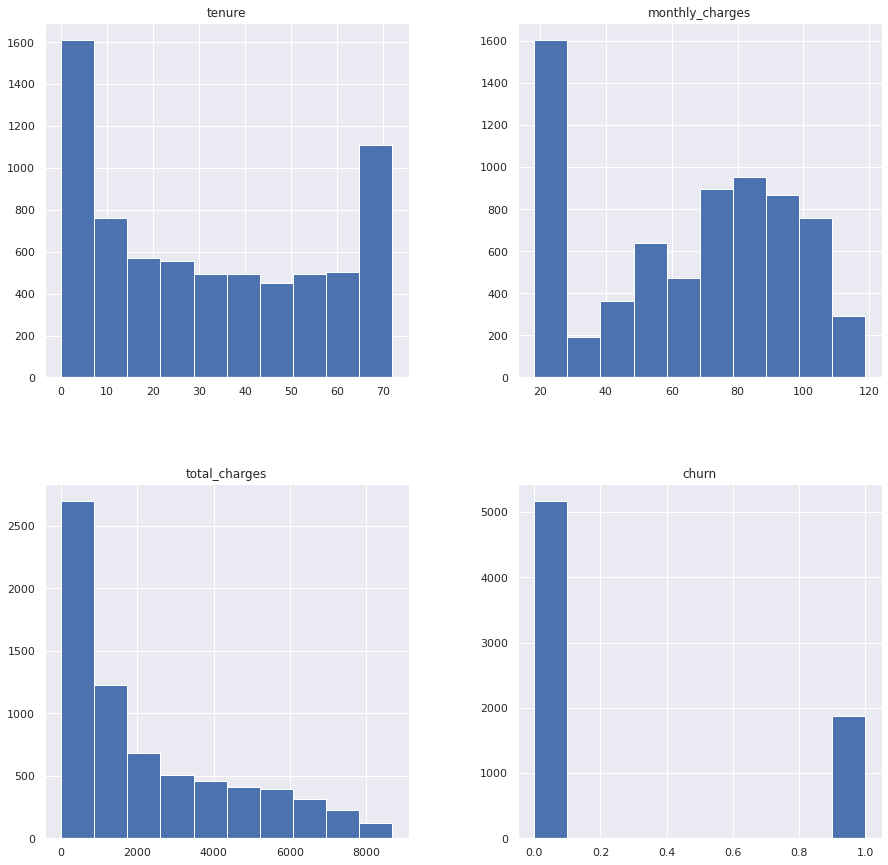

In [466]:
# Histograma
churn_df.hist(figsize = (15,15))
plt.show()

O Gráfico de Densidade, ou Density Plot, confirma a natureza bimodal e trimodal das variáveis **tenure** e **montly_charges**. Por sua vez, **total_charges**, a multiplicacao das duas variáveis anteiores, parece seguir uma distribuição lognormal.

Não iremos aplicar as transformações logarítmicas
Veremos que muitos dos atributos têm uma distribuição distorcida. Uma transformação como a Box-Cox, que pode aproximar a distribuição de uma Normal, pode ser útil neste caso.

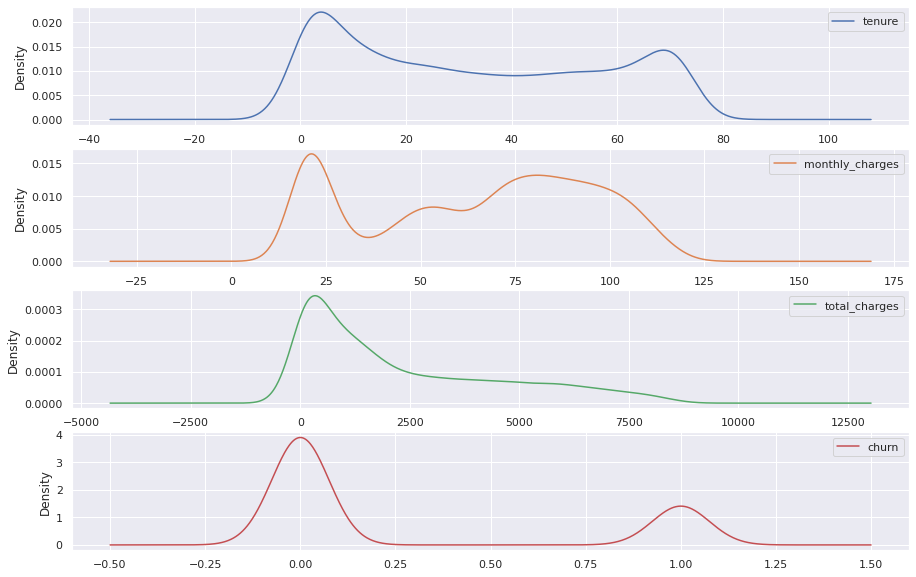

In [467]:
# Density Plot
churn_df.plot(kind = 'density', subplots = True, sharex = False, figsize = (15,10))
plt.show()

A análise dos boxplots não revelam informações novas. Confirma-se apenas que o conjunto de dados não possui outliers e que a variável **total_charges** posui uma cauda longa a sua direita.

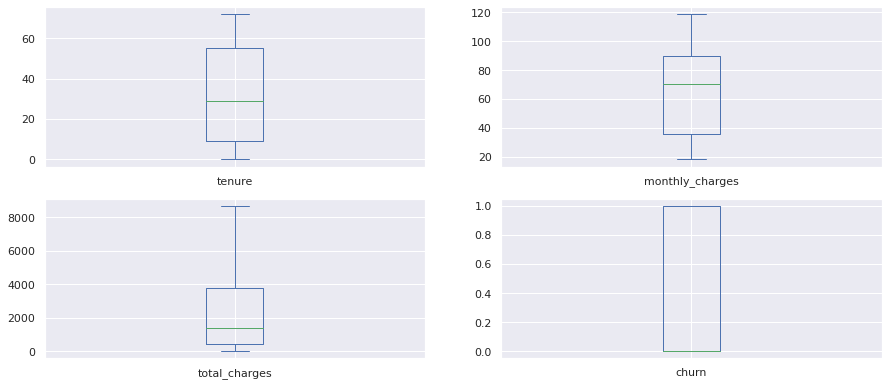

In [468]:
# Boxplot
churn_df.plot(kind = 'box', subplots = True, layout = (3,2), sharex = False, sharey = False, figsize = (15,10))
plt.show()

### 3.3. Visualizações Multimodais

Os algoritmos de correlação mais comumente utilizados (Pearson, Spearman e Kendall) não trabalham com variáveis categóricas.

Por se tratar de um conjunto de dados majoritariamente categórico, utilizaremos o coeficiente de correlação **Phi K** para analisar as variáveis.

O coeficiente de correlação Phi K consegue calcular as correlações entre variáveis categóricas e numéricas analisando o efeito que as variáveis categóricas possuem sobre as variáveis numéricas intervalares.

Diferente de outros algoritmos de para cálculo de correlação, ele consegue capturar de forma adequada relacionamentos não lineares entre variáveis, mas não consegue indicar a direção do relacionamento, apenas se ele existe e sua intensidade, pois os dados retornados variam entre um intervalo entre 0 e 1, sendo que 

* 0: não há correlação entre as variáveis.
* Próximo de 1 : há uma correlação negativa ou positiva entre as variáveis.


In [469]:
# Matriz de Correlação com Matplotlib Seaborn
interval_cols = ['tenure', 'monthly_charges', 'total_charges']

phik_overview_df = churn_df.phik_matrix(interval_cols=interval_cols)
phik_overview_df.sort_values(by="churn", inplace=True, axis=0)
phik_overview_df.sort_values(by="churn", inplace=True, axis=1)
sorted_phik_df = churn_df[ phik_overview_df.index ]
phik_overview_df = sorted_phik_df.phik_matrix(interval_cols=interval_cols)
display(phik_overview_df);



phone_service  multiple_lines  streaming_tv  \
phone_service               1.00            1.00          0.11   
multiple_lines              1.00            1.00          0.59   
streaming_tv                0.11            0.59          1.00   
streaming_movies            0.11            0.59          0.97   
device_protection           0.10            0.56          0.95   
online_backup               0.10            0.56          0.95   
internet_service            0.28            0.74          0.95   
tech_support                0.11            0.54          0.95   
online_security             0.11            0.54          0.94   
partner                     0.02            0.09          0.08   
senior_citizen              0.00            0.09          0.11   
contract                    0.00            0.24          0.55   
dependents                  0.00            0.01          0.09   
total_charges               0.20            0.49          0.57   
paperless_billing           0.02            0.10          0.20   
monthly_charges             0.83            0.71          0.86   
payment_method              0.00            0.17          0.28   
tenure                      0.00            0.37          0.32   
churn                       0.00            0.02          0.14   

                   streaming_movies  device_protection  online_backup  \
phone_service                  0.11               0.10           0.10   
multiple_lines                 0.59               0.56           0.56   
streaming_tv                   0.97               0.95           0.95   
streaming_movies               1.00               0.95           0.95   
device_protection              0.95               1.00           0.95   
online_backup                  0.95               0.95           1.00   
internet_service               0.95               0.94           0.94   
tech_support                   0.95               0.95           0.95   
online_security                0.94               0.95           0.95   
partner                        0.08               0.10           0.09   
senior_citizen                 0.11               0.11           0.11   
contract                       0.55               0.63           0.58   
dependents                     0.08               0.09           0.10   
total_charges                  0.57               0.57           0.57   
paperless_billing              0.20               0.20           0.20   
monthly_charges                0.86               0.83           0.82   
payment_method                 0.29               0.30           0.29   
tenure                         0.33               0.40           0.40   
churn                          0.14               0.17           0.18   

                   internet_service  tech_support  online_security  partner  \
phone_service                  0.28          0.11             0.11     0.02   
multiple_lines                 0.74          0.54             0.54     0.09   
streaming_tv                   0.95          0.95             0.94     0.08   
streaming_movies               0.95          0.95             0.94     0.08   
device_protection              0.94          0.95             0.95     0.10   
online_backup                  0.94          0.95             0.95     0.09   
internet_service               1.00          0.95             0.95     0.00   
tech_support                   0.95          1.00             0.95     0.08   
online_security                0.95          0.95             1.00     0.09   
partner                        0.00          0.08             0.09     1.00   
senior_citizen                 0.16          0.14             0.13     0.02   
contract                       0.51          0.67             0.64     0.18   
dependents                     0.11          0.11             0.12     0.65   
total_charges                  0.51          0.54             0.53     0.42   
paperless_billing              0.23          0.20   



Por ser um algoritmo ainda novo, a interpretação da intensidade dos relacionamentos pode ser um tanto dificultada. Portanto, as linhas e colunas do dataframe contendo as correlações foram ordenados com base na intensidade do relacionamento com a variável target **churn**. Nesse sentido, as constatações anteriormente realizadas via análise das tabulações cruzadas com a variável target são reforçadas/confirmadas.

Ignorando a primeira coluna/linha (por tratar-se da própria variável target após a ordenação citada acima), podemos verificar que as variáveis que possuem a maior correlação com a mesma são:

- **tenure** indicando que os clientes mais novos possuem maior rotatividade e que, com o passar do tempo, tendem a se fidelizar, conforme análise anterior.

- **monthly_charges** indicando que os clientes que contratam os serviços mais caros (internet de fibra ótica) tendem a ter a maior rotatividade e que clientes que possuem apenas planos telefônicos, tendem a apresentar menor rotatividade (conforme análise anterior).

- **payment_method** indicando que os clientes que realizam pagamento via cheques eletrônicos(depósitos diretos) são os que apresentam a maior rotatividade(conforme análise anterior), possivelmente ligado a facilidade na qual os pagamentos podem ser sustados sem necessidade de contato com a operadora.

Existe uma alta correlação entre os diferentes serviços oferecidos e uma correlação dos mesmos com os valores mensais cobrados. Essa relação possivelmente pode ser explicada sobre o efeito que a contratação desses serviços possuem sobre o valor da mensalidade. Nesse sentido, é difícil interpretar as correlações reportadas por falta de uma intuição adequada sobre o seu significado, efeitos e características.

Mais detalhes sobre o coeficiente **Phi K** podem ser encontrados no link abaixo, inclusive o artigo no qual o mesmo foi apresentado.

https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

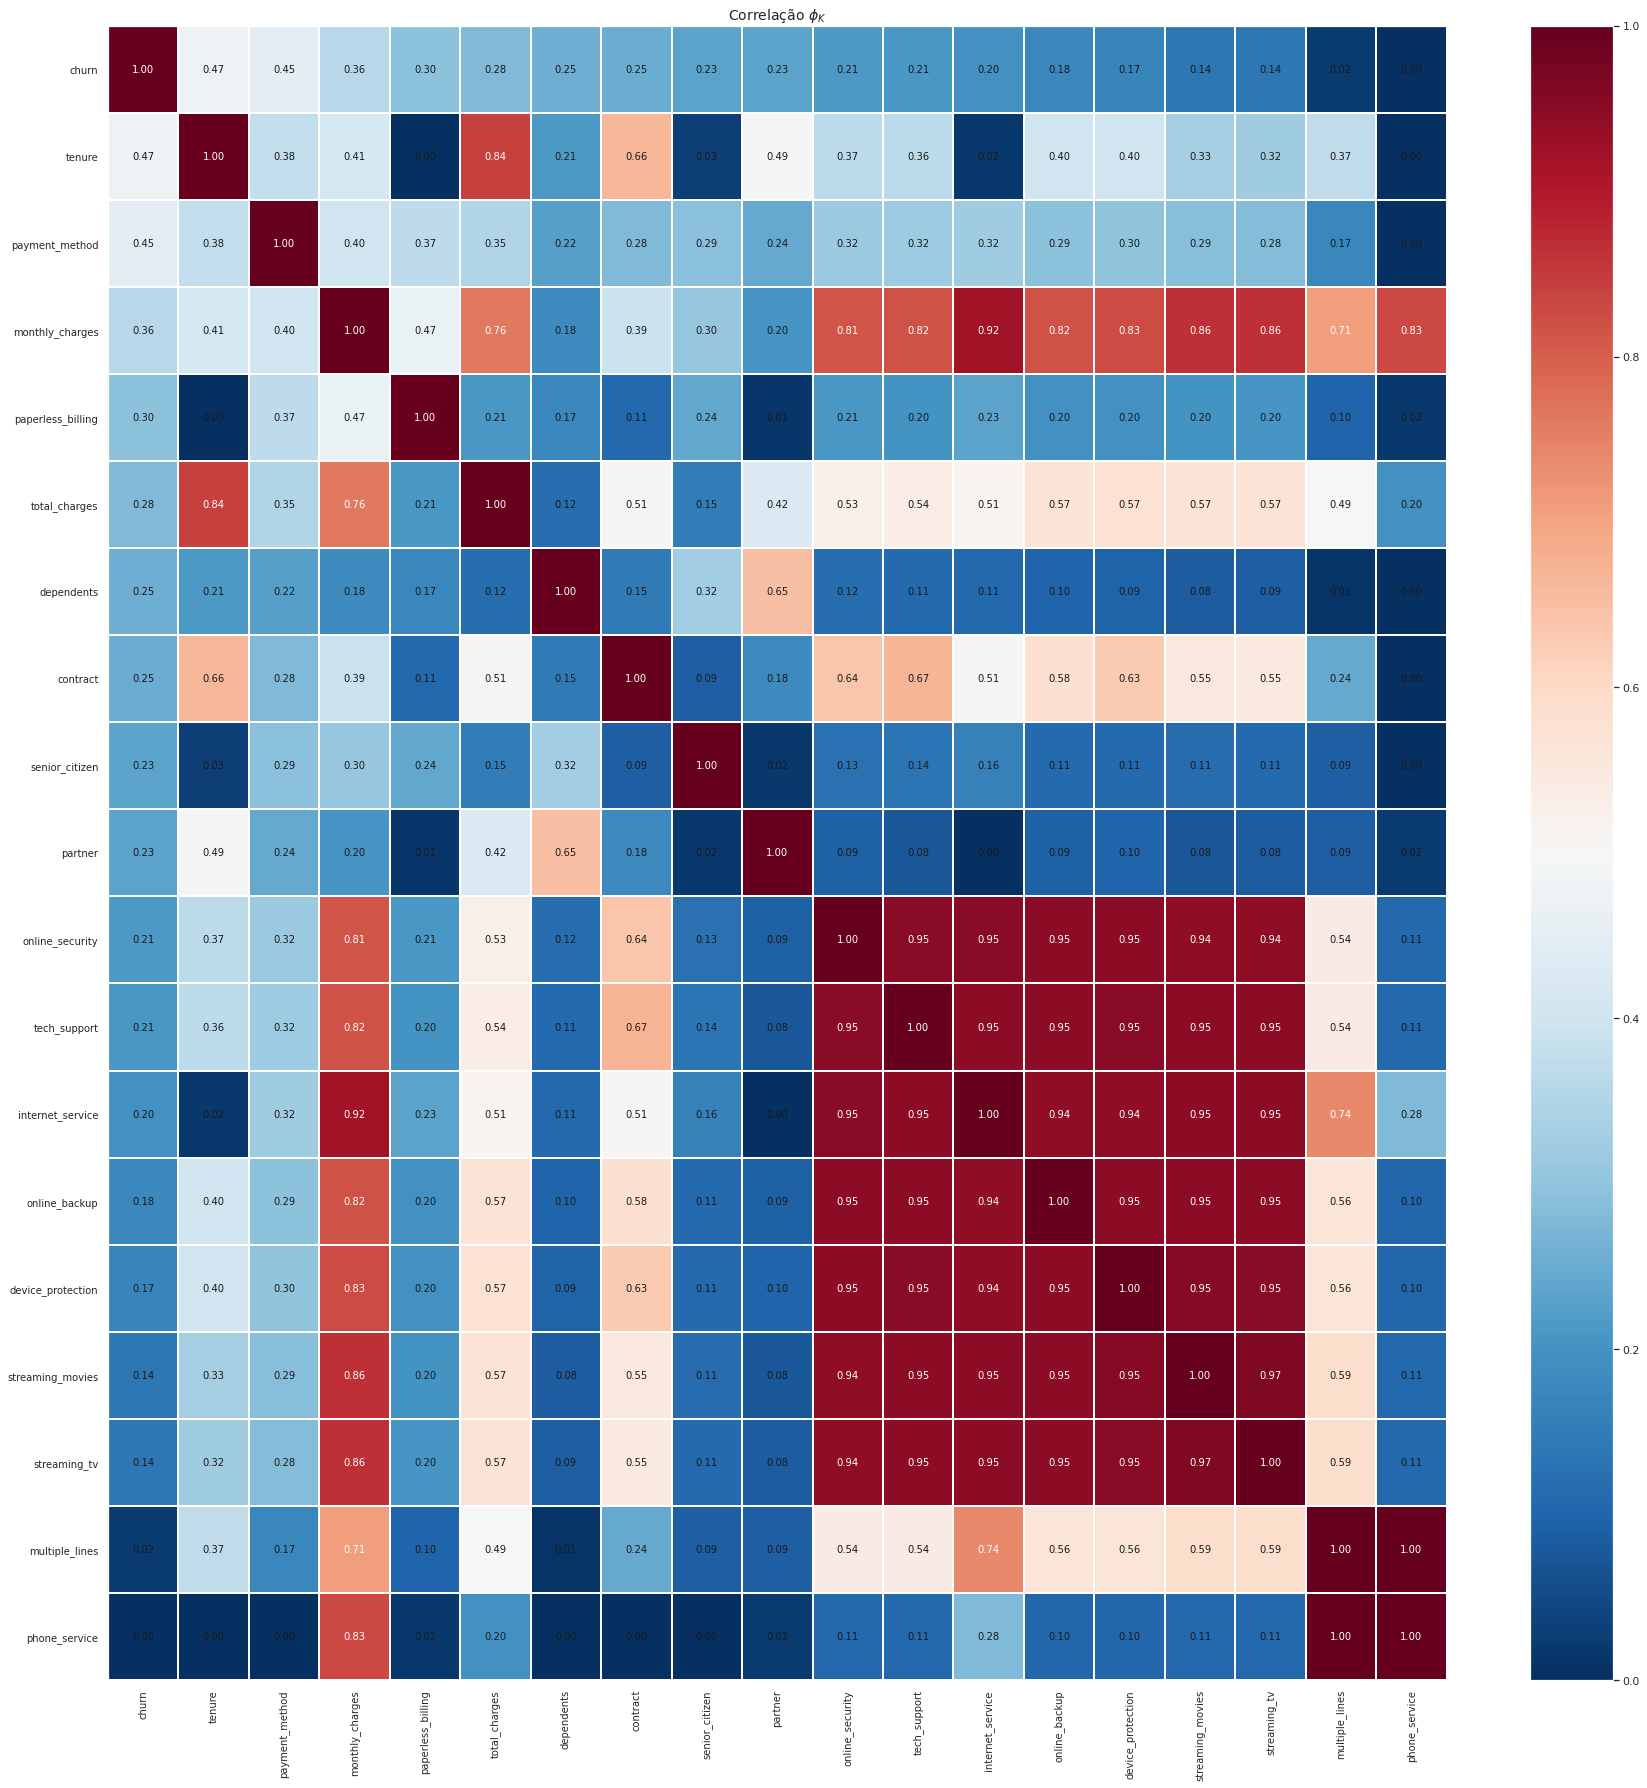

In [470]:


plot_correlation_matrix(
    phik_overview_df.values
,   x_labels          = phik_overview_df.columns
,   y_labels          = phik_overview_df.index
,   vmin              = 0
,   vmax              = 1
,   color_map         = 'RdBu_r'
,   title             = r'Correlação $\phi_K$'
,   figsize=(25,25)
);
plt.tight_layout();


## 4. Pré-Processamento de dados



### 4.1. Tratamento das variáveis categóricas

Dado o elevado número de variáveis categóricas presentes no data set, iremos adotar a estratégia de **Dummy Encoding** para tranformar os dados categóricos em numéricos e posteriormente removendo as colunas redundantes.


In [471]:
# transformando variáveis booleanas em numéricas (dummy encoding não é necessário)
for feature in BOOLEAN_FEATURES:
  churn_df[feature] = churn_df[feature].map(BOOLEAN_MAP)

# realizando o dummy encoding usando pandas
dummy_df = pd.get_dummies(
    data        = churn_df[CATEGORICAL_FEATURES]
,   prefix      = CATEGORICAL_FEATURES
,   prefix_sep  = "="
)

# concatenando as variáveis boleanas, categóricas codificadas, numéricas e variável target num novo dataset
churn_df = pd.concat([
    churn_df[ BOOLEAN_FEATURES ]
,   dummy_df
,   churn_df[ NUMERICAL_FEATURES ]
,   churn_df[ TARGET_VARIABLE ]
], axis=1)

# removendo variáveis equivalentes internet_service=No = 1
del churn_df["device_protection=No internet service"]
del churn_df["streaming_tv=No internet service"]
del churn_df["tech_support=No internet service"]
del churn_df["online_backup=No internet service"]
del churn_df["streaming_movies=No internet service"]
del churn_df["online_security=No internet service"]

# removendo variáveis equivalentes phone_service=0
del churn_df["multiple_lines=No phone service"]

# removendo variáveis codificada tornadas redundantes pelas deleções acima
del churn_df["multiple_lines=No"]
del churn_df["online_security=No"]
del churn_df["online_backup=No"]
del churn_df["device_protection=No"]
del churn_df["tech_support=No"]
del churn_df["streaming_tv=No"]
del churn_df["streaming_movies=No"]
del churn_df["internet_service=No"]


As colunas resultantes foram renomeadas para melhorar a legibilidade do dataframe.

In [472]:
new_column_names = {
    'multiple_lines=Yes'                       : 'multiple_lines'
,   'internet_service=DSL'                     : 'dsl'
,   'internet_service=Fiber optic'             : 'fiber_optic'
,   'online_security=Yes'                      : 'online_security'
,   'online_backup=Yes'                        : 'online_backup'
,   'device_protection=Yes'                    : 'device_protection'
,   'tech_support=Yes'                         : 'tech_support'
,   'streaming_tv=Yes'                         : 'streaming_tv'
,   'streaming_movies=Yes'                     : 'streaming_movies'
,   'contract=Month-to-month'                  : 'monthly_contract'
,   'contract=One year'                        : 'one_year_contract'
,   'contract=Two year'                        : 'two_year_contract'
,   'payment_method=Bank transfer (automatic)' : 'bank_transfer'
,   'payment_method=Credit card (automatic)'   : 'credit_card'
,   'payment_method=Electronic check'          : 'electronic_check'
,   'payment_method=Mailed check'              : 'mailed_check'
}
churn_df.rename(columns=new_column_names, inplace=True)

## 4.2 Feature Engineering

Iremos tentar criar variáveis artificiais combinando as variáveis categóricas codificadas.

O intuito é conseguir simultaneamente capturar as contribuições positivas individuais de variáveis categóricas adicionadas de ruído para gerar variáveis que se comportem como variáveis numéricas intervalares com correlação positiva com a variável target.

Em seguida, utilizaremos o processo de rankeamento de importância de variáveis oferecido pelo classificador **RandomForestoClassifier** para simultaneamente verificar se as variáveis criadas são significativas e para eliminar variáveis consideradas menos importantes.

In [473]:
# salvando o dataset para permitir reexecuções do códigos abaixo
# feature engineering é um processo tediosamente repetitivo
orig_df = churn_df.copy()

In [474]:
churn_df = orig_df.copy()
# o primeiro quartil da variável tenure conforme análise univariada anterior.
# a probabilidade de rotatividade é inversamente proporcional à variável tenure
tenure_1st_quartile = 9 
# o terceiro quartil da variável monthly_charges conforme análise univariada anterior.
# a probabilidade de rotatividade é  proporcional à variável monthly_charges
charges_3rd_quartile = 89.85

# ruído a ser adicionado para evitar overfitting e fazer as variáveis novas parecerem numéricas
noise_std = 0.1
# quantidade de linhas necesário para criação do ruído
rows, cols = churn_df.shape

# client factor
# A análise das tabulações cruzadas revelou que a existência de parceiro e dependentes tendem a fidelizar o cliente.
# Em contrapartida, observou-se que clientes na terceira idade proporcionalmente tendem a cancelar os serviços
# de maneira mais frequente.
# A expectativa é de que quanto maior for o client_factor, maior a probabilidade de que ele venha a cancelar o seu contrato
noise_term = np.random.normal(loc=0.0, scale=noise_std, size=rows)
churn_df["client_factor"] = ((
    np.exp(churn_df["senior_citizen"]) # senior_citizen=1 aumenta a rotatividade
+   np.exp(np.abs(1-churn_df["partner"]))
+   np.exp(np.abs(1-churn_df["dependents"]))
+   np.exp((churn_df["tenure"] < tenure_1st_quartile).astype(float))
+   np.exp((churn_df["monthly_charges"] > charges_3rd_quartile).astype(float))
) / 3.0 + noise_term)

# internet factor
# A análise das tabulações cruzadas revelou que a existência a contratação dos
# serviços de suporte técnico e de segurança online tendem a indicar que um usuário
# encontra-se fidelizado. A contratação da internet de fibra ótica, ao elevar o valor
# mensalmente cobrado, contribui com a rotatividade do cliente. Por outro lado,
# os clientes com internet DSL tendem a permanecer como cliente devido a valor 
# comparativamente mais baixo sendo cobrado.
# A expectativa é de que quanto maior for o internet_factor, maior a probabilidade de que ele venha a cancelar o seu contrato
noise_term = np.random.normal(loc=0.0, scale=noise_std, size=rows)
churn_df["internet_factor"] = ((
    np.exp(np.abs(1-churn_df["tech_support"])) 
+   np.exp(np.abs(1-churn_df["online_security"]))  
+   np.exp(churn_df["fiber_optic"]) # senior_citizen=1 aumenta a rotatividade
-   np.exp(churn_df["dsl"]) # dsl=1 diminui a rotatividade
+   np.exp((churn_df["tenure"] < tenure_1st_quartile).astype(float))
+   np.exp((churn_df["monthly_charges"] > charges_3rd_quartile).astype(float))
) / 3.0 + noise_term)

# financial factor
# A análise das tabulações cruzadas revelou que a existência o uso de cobrança digital,
# o uso de contratos mensais e o pagamento via cheque eletrônico são fatores que
# contribuem com a rotatividade dos clientes
# A expectativa é de que quanto maior for o financial_factor, maior a probabilidade de que ele venha a cancelar o seu contrato
noise_term = np.random.normal(loc=0.0, scale=noise_std, size=rows)
churn_df["financial_factor"] = ((
    np.exp(churn_df["monthly_contract"]) 
+   np.exp(churn_df["electronic_check"])
+   np.exp(churn_df["paperless_billing"])
+   np.exp((churn_df["tenure"] < tenure_1st_quartile).astype(float))
+   np.exp((churn_df["monthly_charges"] > charges_3rd_quartile).astype(float))
) / 3.0 + noise_term)

# por último, criamos um fator combinando todos usados anteriormente
noise_term = np.random.normal(loc=0.0, scale=noise_std, size=rows)
churn_df["multi_factor"] = ((
    np.exp(churn_df["senior_citizen"]) # senior_citizen=1 piora as p
+   np.exp(np.abs(1-churn_df["partner"]))
+   np.exp(np.abs(1-churn_df["dependents"]))
+   np.exp(np.abs(1-churn_df["tech_support"])) 
+   np.exp(np.abs(1-churn_df["online_security"])) 
-   np.exp(churn_df["dsl"]) 
+   np.exp(churn_df["fiber_optic"])
+   np.exp(churn_df["monthly_contract"]) 
+   np.exp(churn_df["electronic_check"])
+   np.exp(churn_df["paperless_billing"])
+   np.exp((churn_df["tenure"] < tenure_1st_quartile).astype(float))
+   np.exp((churn_df["monthly_charges"] > charges_3rd_quartile).astype(float))
) / 9.0 + noise_term)

churn_df["churn"] = churn_df.pop("churn")
churn_df.describe()

senior_citizen  partner  dependents  phone_service  paperless_billing  \
count         7043.00  7043.00     7043.00        7043.00            7043.00   
mean             0.16     0.48        0.30           0.90               0.59   
std              0.37     0.50        0.46           0.30               0.49   
min              0.00     0.00        0.00           0.00               0.00   
25%              0.00     0.00        0.00           1.00               0.00   
50%              0.00     0.00        0.00           1.00               1.00   
75%              0.00     1.00        1.00           1.00               1.00   
max              1.00     1.00        1.00           1.00               1.00   

       multiple_lines     dsl  fiber_optic  online_security  online_backup  \
count         7043.00 7043.00      7043.00          7043.00        7043.00   
mean             0.42    0.34         0.44             0.29           0.34   
std              0.49    0.47         0.50             0.45           0.48   
min              0.00    0.00         0.00             0.00           0.00   
25%              0.00    0.00         0.00             0.00           0.00   
50%              0.00    0.00         0.00             0.00           0.00   
75%              1.00    1.00         1.00             1.00           1.00   
max              1.00    1.00         1.00             1.00           1.00   

       ...  electronic_check  mailed_check  tenure  monthly_charges  \
count  ...           7043.00       7043.00 7043.00          7043.00   
mean   ...              0.34          0.23   32.37            64.76   
std    ...              0.47          0.42   24.56            30.09   
min    ...              0.00          0.00    0.00            18.25   
25%    ...              0.00          0.00    9.00            35.50   
50%    ...              0.00          0.00   29.00            70.35   
75%    ...              1.00          0.00   55.00            89.85   
max    ...              1.00          1.00   72.00           118.75   

       total_charges  client_factor  internet_factor  financial_factor  \
count        7043.00        7043.00          7043.00           7043.00   
mean         2279.73           2.74             2.49              2.80   
std          2266.79           0.67             0.89              0.76   
min             0.00           1.35             0.45              1.33   
25%           398.55           2.23             1.90              2.21   
50%          1394.55           2.80             2.53              2.81   
75%          3786.60           3.32             3.10              3.38   
max          8684.80           4.67             4.47              4.72   

       multi_factor   churn  
count       7043.00 7043.00  
mean           2.04    0.27  
std            0.50    0.44  
min            0.72    0.00  
25%            1.67    0.00  
50%            2.05    0.00  
75%            2.41    1.00  
max            3.42    1.00  

[8 rows x 29 columns]

Os gráficos de dispersão entre as variáveis

As variáveis **cient_factor**, **internet_factor** e **financial_factor** possuem distribuições resultante n-modais com a rotatividade aumentando de acordo com o aumento da mesma.

A variável **multi_factor** aparenta funcionar como uma mistura de 2 modelos gaussianos.

Todas as variáveis novas apresentam algum grau de correlação positivo, como projetado.

O processo de *feature engineering* teve de ser interrompido por falta de tempo.

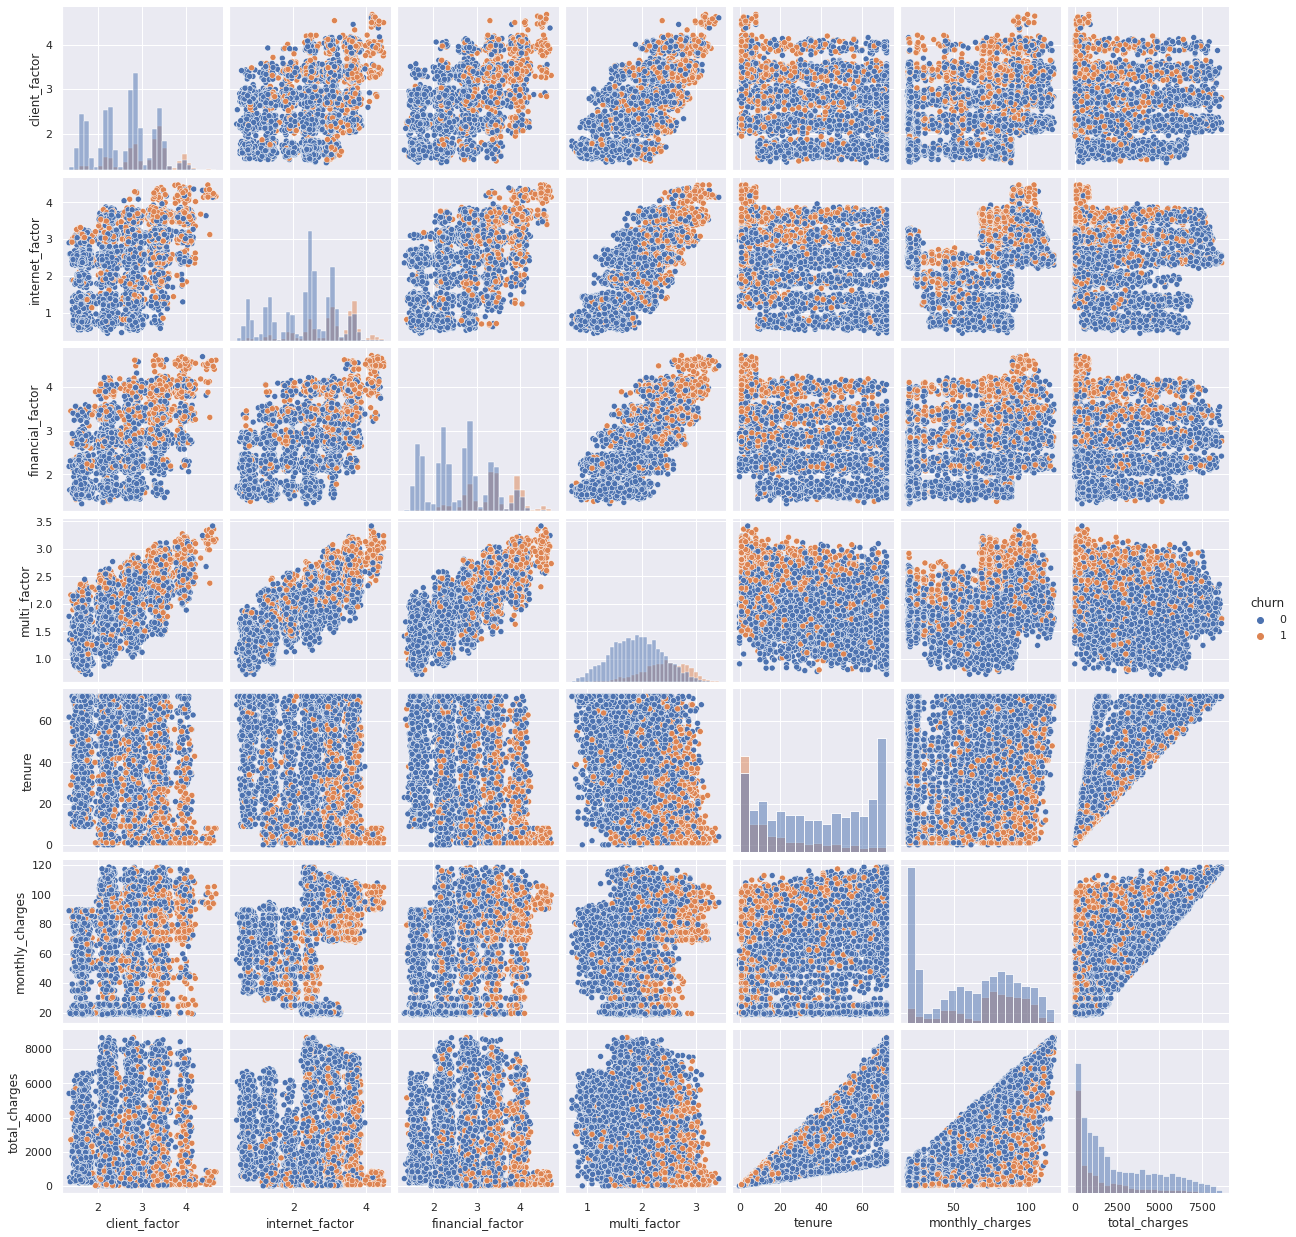

In [475]:
scatter_vars = [
  "client_factor", 
  "internet_factor", 
  "financial_factor", 
  "multi_factor", 
  "tenure",
  "monthly_charges",
  "total_charges"
]

sns.pairplot(
    churn_df
,   diag_kind = "hist"    
,   vars      = scatter_vars
,   hue       = "churn"
)


### 4.3. Cômputo da importância das variáveis

Uma instância do classificador **RandomForestoClassifier** será treinado para verificação das importâncias das 29 variáveis presentes no dataset.

Das 4 variáveis artificiais criadas, 4 constam no top 8 variáveis mais importantes e 3 no top 3 variáveis mais importantes, indicando que o esforço para construção das mesmas foi justificado.

Obs: Dado a aleatoriedade utilizada no algoritmo **RandomForestClassifier**, a utilização do parâmetro *random_state* não é suficiente para garantir determinismo do resultado. Como esse notebook está usando modelos salvos para execução mais rápida, é preciso salvar também o modelo utilizado para remoção de colunas de menor importância pois os modelos treinados e salvos foram construídos utilizando pipelines que esperam um conjunto específico de colunas



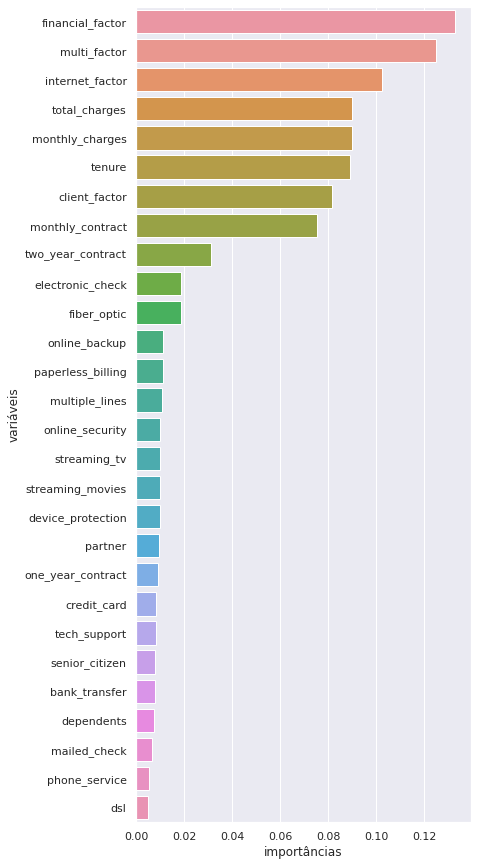

In [476]:
# cômputo da importância das variáveis utilizando RandomForest
all_but_target = churn_df.columns.difference([TARGET_VARIABLE])
X_df = churn_df[all_but_target]
y = churn_df[TARGET_VARIABLE]

if TRAIN_ALL:
  classifier = RandomForestClassifier(
      n_estimators  = 150
  ,   bootstrap     = True   
  ,   class_weight  = "balanced_subsample"
  ,   random_state  = RANDOM_STATE
  )
  classifier.fit(X_df, y)
  with open(FEATURE_IMPORTANCE_MODEL_FILE, "wb") as fh:
    pickle.dump(classifier, fh)
else:
  with open(FEATURE_IMPORTANCE_MODEL_FILE, "rb") as fh:
    classifier = pickle.load(fh)

importances = classifier.feature_importances_
std = np.std([ classifier.feature_importances_ for tree in classifier.estimators_], axis=0)
importances_df = pd.DataFrame({
    "variáveis"       : X_df.columns
,   "importâncias"    : importances
,   "desv.pad"        : std
})

f, ax = plt.subplots(figsize=(6, 15))
importances_df.sort_values("importâncias", ascending=False, inplace=True)
sns.barplot(
    x     = "importâncias"
,   y     = "variáveis"
,   data  =  importances_df
)


Das 29 variáveis presentes no dataset, serão mantidas apenas 16.

Esperamos com isso diminuir o tempo de treino e diminuir a variância dos modelos que serão treinados.

In [477]:
# removendo variáveis menos importantes
keep_n_columns    = 16
kept_columns      = importances_df["variáveis"][0:keep_n_columns].to_list()
not_kept_columns  = X_df.columns.difference(kept_columns)
X_df              = X_df[ kept_columns ] 
X_df

financial_factor  multi_factor  internet_factor  total_charges  \
0                 4.01          2.44             2.47          29.85   
1                 1.49          1.60             1.34        1889.50   
2                 3.38          1.95             1.97         108.15   
3                 1.58          1.42             0.91        1840.75   
4                 3.89          2.96             3.60         151.65   
...                ...           ...              ...            ...   
7038              2.33          1.18             0.60        1990.50   
7039              2.95          2.03             3.66        7362.90   
7040              3.24          1.76             1.45         346.45   
7041              3.24          2.56             3.61         306.60   
7042              2.92          2.06             2.50        6844.50   

      monthly_charges  tenure  client_factor  monthly_contract  \
0               29.85       1           2.87                 1   
1               56.95      34           2.91                 0   
2               53.85       2           3.47                 1   
3               42.30      45           2.77                 0   
4               70.70       2           3.62                 1   
...               ...     ...            ...               ...   
7038            84.80      24           1.57                 0   
7039           103.20      72           2.31                 0   
7040            29.60      11           1.61                 1   
7041            74.40       4           3.35                 1   
7042           105.65      66           3.40                 0   

      two_year_contract  electronic_check  fiber_optic  online_backup  \
0                     0                 1            0              1   
1                     0                 0            0              0   
2                     0                 0            0              1   
3                     0                 0            0              0   
4                     0                 1            1              0   
...                 ...               ...          ...            ...   
7038                  0                 0            0              0   
7039                  0                 0            1              1   
7040                  0                 1            0              0   
7041                  0                 0            1              0   
7042                  1                 0            1              0   

      paperless_billing  multiple_lines  online_security  streaming_tv  
0                     1               0                0             0  
1                     0               0                1             0  
2                     1               0                1             0  
3                     0               0                1             0  
4                     1               0                0             0  
...                 ...             ...              ...           ...  
7038                  1               1                1             1  
7039                  1               1                0             1  
7040                  1               0                1             0  
7041                  1               1                0             0  
7042                  1               0                1             1  

[7043 rows x 16 columns]

### 4.4. Separação em conjunto de treino e conjunto de teste

Para evitar que os processo de treino do modelo resulte em um modelo sobreajustado aos dados (overfitting) é importante testar o modelo com dados ainda não vistos. Modelos sobreajustados tendem a ter uma performance pior estes dados, sendo isso um forte indicativo de que o modelo não foi capaz de generalizar seu poder preditivo.

É uma boa prática usar um conjunto de teste, uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final.

Trata-se de um boa prática usada para avaliação sistemática da performance do modelo.

Usaremos 80% do conjunto de dados para modelagem e treino, e guardaremos 20% para teste, usando a estratégia train-test-split.

In [478]:
X_train, X_test, y_train, y_test = train_test_split(
    X_df.values
,   y
,   test_size     = TEST_PCT_SIZE
,   shuffle       = True
,   random_state  = RANDOM_STATE
,   stratify      = y # com estratificação
)

X_train_df = pd.DataFrame(X_train, columns=X_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_df.columns)
y_train_df = pd.DataFrame(y_train, columns=[TARGET_VARIABLE])
y_test_df = pd.DataFrame(y_test, columns=[TARGET_VARIABLE])

## 5. Modelos de Classificação

### 5.1. Criação do pipeline genérico

Todos os algoritmos, com exceção do **EnsembleVoteClassifier**, usarão um único pipeline durante o processo de ajuste dos hiperparâmetros. Neste pipeline, o próprio classificador e seus parâmetros serão alterado durante a busca.

O pipeline é composto por:

- Um transformador de colunas que aplicará um escalonamento (normalização ou padronização) ou não nas variáveis numéricas.
  - As variáveis categóricas codificadas com dummy enconding não são escaladas

- Uma etapa de redução de dimensionalidade que executará ou não redução de dimenionalidade usando PCA
  - Em versões anteriores desse notebook tentou-se utilizar LDA, mas não foi observado nenhum caso onde essa operação tenha ajudado de maneira significativa nos modelos treinados.

- Uma etapa de classificação, propriamente dita, onde o classificador e seus hiperparâmetros são de fato configurados durante a busca no espaço de hiperparâmetros.

Os melhores pipelines encontrados serão exibidos graficamente como o exemplo abaixo

In [479]:
# Configuração do pipeline

# Os transformadores numéricos são utilizado spara processamento de todas as variáveis não categóricas.
numeric_transformer = Pipeline([
  ("scaler", StandardScaler())    
])

column_transformer = ColumnTransformer(
  transformers = [
    ("num", numeric_transformer, NUMERICAL_FEATURES_AFTER_FEAT_ENG)
  ],
  # importante usar passthrough quando nem todos os atributos forem processados
  remainder="passthrough" 
)

# Este pipelie será ajustado diversas vezes durante o processo de otimização dos hiper parâmetros.
pipeline = Pipeline([
    # a primeira fase consiste no pré-processamento das variáveis numéricas
    ("feature_scaling", column_transformer),
    # redução de dimesionalidade
    ("reduce_dim", PCA()),
    # O algoritmo de regressão e seus parâmetros serão configurados via gridsearch
    ("classifier", SVC())
])
pipeline

Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', PCA()), ('classifier', SVC())])

### 5.2. Validação Cruzada

Durante o processo de treino dos algoritmos, utilizaremos a validação cruzada estratificada usando 10 folds por estarmos trabalhando com um conjunto de dados desbalanceado.


In [480]:
# Parâmetros e partições da validação cruzada estratificada
kfold = StratifiedKFold(
    n_splits      = K_FOLDS
,   shuffle       = True
,   random_state  = RANDOM_STATE
) 



### 5.3. Persistência de modelos

Dado a lentidão do processo de treino, as funções abaixo serão utilizadas para salvar e ler os melhores modelos encontrados durante a busca de hiperparâmetros.

O classificador **EnsembleVoteClassifier** usará um método específico de persistência pois esta classe da biblioteca **mlxtend** não funciona com o framework de busca de hiperparâmetros do **scikit-learn**

In [481]:
def save_model(grid, file_name):
  import pickle
  data = {
    "best_score_"     : grid.best_score_
  , "best_params_"    : grid.best_params_
  , "best_estimator_" : grid.best_estimator_
  , "cv_results_"     : grid.cv_results_
  , "grid"            : grid
  }  
  with open(file_name, "wb") as fh:
    pickle.dump(data, fh)

def read_model(file_name):
  import pickle
  with open(file_name, "rb") as fh:
    data                  = pickle.load(fh)
  grid                  = data["grid"]
  grid.best_score_      = data["best_score_"]
  grid.best_params_     = data["best_params_"]
  grid.best_estimator_  = data["best_estimator_"]
  grid.cv_results_      = data["cv_results_"]
  return grid

### 5.4. Busca de hiperparâmetros

A busca de hiperparâmetros ocorrerá usando o pipeline genérico anteriormente visto e uma grade de parâmetros.

A grade de parâmetros será explorada aleatoriamente mediante do uso da classe **RandomizedSearchCV** usando a métrica **recall**.

Esta métrica foi escolhida pois entendemos que o modelo deve conseguir identificar o máximo de clientes correndo risco de cancelarem os serviços e que, nesse contexto, a ocorrência de falsos positivos não é tão danoso para o negócio quanto à ocorrência de falsos negativos.

Apesar de **recall** ter sido escolhida como a principal métrica de treino, iremos acompanhar também outras métricas para garantir que o modelo escolhido ao final corresponda às expectativas e necessidades do negócio.

In [482]:
# configura pandas para exibição de apenas duas casas decimais nas variaveis
pd.set_option('display.float_format', lambda x: '%0.3f' % x)

def search_hyperparameters(param_grid, num_iter, algo):
  model_settings = MODEL_SETTINGS[algo]
  if model_settings["train"]:
    grid = RandomizedSearchCV(
        estimator           = pipeline
    ,   param_distributions = param_grid
    ,   scoring             = SCORING_METRIC
    ,   cv                  = kfold
    ,   n_iter              = num_iter
    ,   return_train_score  = RETURN_TRAIN_SCORE
    )
    grid.fit(X_train_df, y_train_df)
    save_model(grid, model_settings["model_file"])
  else:
    grid = read_model(model_settings["model_file"])
  print(f"Melhor recall: {grid.best_score_}")
  print("Melhor estimador -> ")
  #pprint(grid.best_params_)
  display(grid.best_estimator_)
  results_df = pd.DataFrame(grid.cv_results_)
  results_df.to_excel(OUTPUT_TRAINING_FILE_TMPLT.replace("{algo}", algo))
  return grid, results_df


  





### 5.4. Exibição dos recalls médios e suas variâncias

Para entender a efetividade da busca de hiperparâmetros serão exibidos gráficos de dispersão do recall médio x o desvio padrão dos recalls.

Em cada gráfico, um hiperparâmetro poderá ser exibido para distinguir os modelos e como o mesmo afeta o recall.

In [483]:
def plot_mean_std(results_df, param_name, new_name):
  df = results_df.copy()
  df[new_name] = results_df[param_name]
  df.sort_values("mean_test_score", ascending=False, inplace=True)
  sns.histplot(
      data=df
  ,   y="mean_test_score"
  ,   hue=new_name
  ,   multiple="stack"
  )
  plt.show()
  sns.scatterplot(
      data=df
  ,   x="mean_test_score"
  ,   y="std_test_score"
  ,   hue=new_name
  )
  plt.show()

### 5.5. Exibição dos hiper parâmetros

Para cada algoritmo será exibido uma lista dos hiperparâmetros top 50 modelos para permitir que seja identificado quais hiperparâmetros são os mais importantes.

In [484]:
def show_top_n(results_df, n, column_mapping):
  results_df.sort_values("mean_test_score", inplace=True, ascending=False)
  columns = {new_name: results_df[col_name] for new_name, col_name in column_mapping.items()}
  params_df = pd.DataFrame(columns)
  display(params_df.head(n))
  return params_df

### 5.6. Exibição do melhor estimador

Realizado a busca de hiperparâmetros, serão exibidas as métricas de acurácia, precisão, recall, score F1 e a área sob a curva ROC do melhor estimador.

É importante monitorar estas métricas pois a otimização dos hiperparâmetros avaliando o recall pode criar cenários com elevados falsos positivos.

O cômputo e exibição das mesmas também ajudará, posteriormente, na seleção do melhor algoritmo.

In [485]:
def report_results(grid, algo):
  y_test_hat              = grid.best_estimator_.predict(X_test_df)
  y_test_prob             = grid.best_estimator_.predict_proba(X_test_df)[:,1]
  
  acc_test_score          = accuracy_score(y_test, y_test_hat)  
  prec_test_score         = precision_score(y_test, y_test_hat)  
  rec_test_score          = recall_score(y_test, y_test_hat)  
  f1_test_score           = f1_score(y_test, y_test_hat)
  rocauc_test_auc         = roc_auc_score(y_test, y_test_prob)
  
  print(f"== Test accuracy score  :  {acc_test_score} ===")
  print(f"== Test precision score :  {prec_test_score} ===")
  print(f"== Test recall score    :  {rec_test_score} ===")
  print(f"== Test F1 Score        :  {f1_test_score} ===")
  print(f"== Test ROC AUC         :  {rocauc_test_auc} ===")
  
  algo_name = MODEL_SETTINGS[algo]['name']
  RESULT_COLUMNS = []
  RESULTS[algo] = {
      "algoritmo"     : algo_name
  ,   "acurácia"      : acc_test_score
  ,   "precisão"      : prec_test_score
  ,   "recall"        : rec_test_score
  ,   "F1"            : f1_test_score
  ,   "ROC AUC"       : rocauc_test_auc
  }
  
  plot_confusion_matrix(grid.best_estimator_, X_test_df, y_test_df)
  plt.show()
  plot_precision_recall_curve(grid.best_estimator_, X_test_df, y_test_df)
  plt.show()
  plot_roc_curve(grid.best_estimator_, X_test_df, y_test_df)
  plt.show()
  print(classification_report(y_test, y_test_hat))


### 6. Regressão Logística

A grade abaixo contém as variações de hiperparâmetros que serão testados.

Será testado o algoritmo sem nenhuma regularização e o algoritmo com regularização ElasticNet. No segundo caso, o parâmetro l1_ratio, que controla a mistura entre a regularização l1 e l2 será utilizada. Como esse parâmetro pode variar entre 0 e 1, isto indica que a regularização Ridge e Lasso também estarão sendo testadas.

Obs: o único solucionador capaz de lidar com ElasticNet é o solucionador "saga". Este solucionador requer que as variáveis estejam aproximadamente na mesma escala.

In [486]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # Logistic Regression
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [LogisticRegression()],
    "classifier__n_jobs"            : [-1], # all cpus available
    "classifier__penalty"           : ["elasticnet"],
    "classifier__class_weight"      : ["balanced"],
    "classifier__solver"            : ["saga"],
    "classifier__l1_ratio"          : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  },
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [LogisticRegression()],
    "classifier__n_jobs"            : [-1], # all cpus available
    "classifier__penalty"           : ["none"],
    "classifier__class_weight"      : ["balanced"],
  }  
]
if QUICK_RUN:
  logreg_grid, logreg_results_df =  search_hyperparameters(param_grid, 20, "logreg")
else:
  logreg_grid, logreg_results_df =  search_hyperparameters(param_grid, 200, "logreg")

Melhor recall: 0.8103975535168196
Melhor estimador -> 


Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   'passthrough')]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    penalty='none'))])

O melhor resultado obtido com a regressão logística foi um recall de 0.810 com um desvio padrão de 0.0225 sem o uso de regularização ElasticNet.

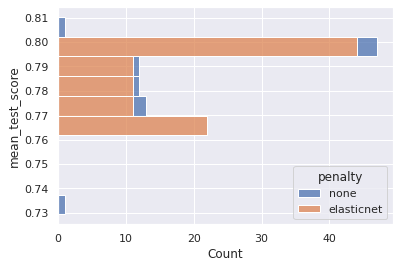

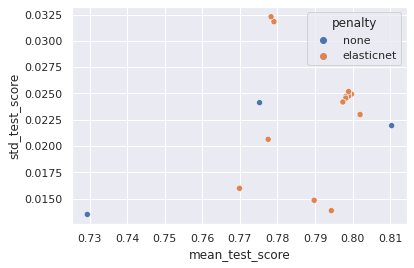

In [487]:
plot_mean_std(logreg_results_df, "param_classifier__penalty", "penalty")

Observando os hiperparâmetros do top 50 modelos, podemos observar que a maioria utiliza ElasticNet sem nenhum tipo de escalonamento de variáveis e sem execução de redução de dimensionalidade.

Nesse caso específico, a regularização parece ter um efeito insignificante na performance do modelo.

In [488]:
column_mapping={
    "mean_score"      : "mean_test_score"
,   "std_score"       : "std_test_score"
,   "l1_ratio"        : "param_classifier__l1_ratio"
,   "penalty"         : "param_classifier__penalty"
,   "feature_scaling" : "param_feature_scaling__num__scaler"
,   "reduce_dim"      : "param_reduce_dim"
}
logreg_params_df = show_top_n(logreg_results_df, 50, column_mapping)

mean_score  std_score l1_ratio     penalty   feature_scaling  \
99        0.810      0.022      NaN        none       passthrough   
0         0.802      0.023    0.000  elasticnet       passthrough   
18        0.802      0.023    0.200  elasticnet       passthrough   
90        0.802      0.023    1.000  elasticnet       passthrough   
81        0.802      0.023    0.900  elasticnet       passthrough   
72        0.802      0.023    0.800  elasticnet       passthrough   
63        0.802      0.023    0.700  elasticnet       passthrough   
45        0.802      0.023    0.500  elasticnet       passthrough   
36        0.802      0.023    0.400  elasticnet       passthrough   
27        0.802      0.023    0.300  elasticnet       passthrough   
54        0.802      0.023    0.600  elasticnet       passthrough   
9         0.802      0.023    0.100  elasticnet       passthrough   
3         0.800      0.025    0.000  elasticnet    MinMaxScaler()   
75        0.799      0.025    0.800  elasticnet    MinMaxScaler()   
57        0.799      0.025    0.600  elasticnet    MinMaxScaler()   
12        0.799      0.025    0.100  elasticnet    MinMaxScaler()   
96        0.799      0.025    1.000  elasticnet  StandardScaler()   
87        0.799      0.025    0.900  elasticnet  StandardScaler()   
30        0.799      0.025    0.300  elasticnet    MinMaxScaler()   
66        0.799      0.025    0.700  elasticnet    MinMaxScaler()   
39        0.799      0.025    0.400  elasticnet    MinMaxScaler()   
93        0.799      0.025    1.000  elasticnet    MinMaxScaler()   
21        0.799      0.025    0.200  elasticnet    MinMaxScaler()   
84        0.799      0.025    0.900  elasticnet    MinMaxScaler()   
78        0.798      0.025    0.800  elasticnet  StandardScaler()   
60        0.798      0.025    0.600  elasticnet  StandardScaler()   
69        0.798      0.025    0.700  elasticnet  StandardScaler()   
48        0.798      0.025    0.500  elasticnet    MinMaxScaler()   
105       0.798      0.025      NaN        none  StandardScaler()   
102       0.798      0.025      NaN        none    MinMaxScaler()   
51        0.798      0.025    0.500  elasticnet  StandardScaler()   
6         0.797      0.024    0.000  elasticnet  StandardScaler()   
15        0.797      0.024    0.100  elasticnet  StandardScaler()   
42        0.797      0.024    0.400  elasticnet  StandardScaler()   
33        0.797      0.024    0.300  elasticnet  StandardScaler()   
24        0.797      0.024    0.200  elasticnet  StandardScaler()   
86        0.794      0.014    0.900  elasticnet    MinMaxScaler()   
41        0.794      0.014    0.400  elasticnet    MinMaxScaler()   
50        0.794      0.014    0.500  elasticnet    MinMaxScaler()   
59        0.794      0.014    0.600  elasticnet    MinMaxScaler()   
95        0.794      0.014    1.000  elasticnet    MinMaxScaler()   
32        0.794      0.014    0.300  elasticnet    MinMaxScaler()   
23        0.794      0.014    0.200  elasticnet    MinMaxScaler()   
68        0.794      0.014    0.700  elasticnet    MinMaxScaler()   
104       0.794      0.014      NaN        none    MinMaxScaler()   
5         0.794      0.014    0.000  elasticnet    MinMaxScaler()   
14        0.794      0.014    0.100  elasticnet    MinMaxScaler()   
77        0.794      0.014    0.800  elasticnet    MinMaxScaler()   
58        0.790      0.015    0.600  elasticnet    MinMaxScaler()   
67        0.790      0.015    0.700  elasticnet    MinMaxScaler()   

              reduce_dim  
99           passthrough  
0            passthrough  
18           passthrough  
90           passthrough  
81           passthrough  
72           passthrough  
63           passthrough  
45           passthrough  
36           passthrough  
27           passthrough  
54           passthrough  
9            passthrough  
3            passthrough  
75           passthrough  
57           passthrough  
12           passthrough  
96           passthrough  

Segue abaixo as métricas apuradas para comparação posterior.

== Test accuracy score  :  0.7288215806909607 ===
== Test precision score :  0.49349240780911063 ===
== Test recall score    :  0.8110516934046346 ===
== Test F1 Score        :  0.6136210384356034 ===
== Test ROC AUC         :  0.8346024679787566 ===


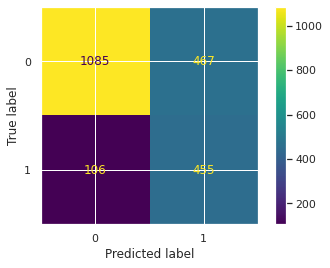

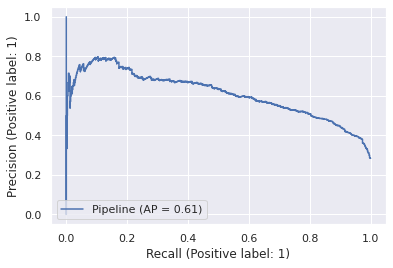

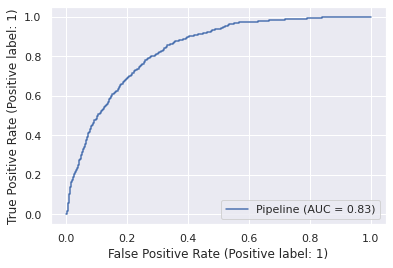

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1552
           1       0.49      0.81      0.61       561

    accuracy                           0.73      2113
   macro avg       0.70      0.76      0.70      2113
weighted avg       0.80      0.73      0.74      2113



In [489]:
report_results(logreg_grid, "logreg")

### 7. KNN

A grade abaixo contém as variações de hiperparâmetros que serão testados.

Os principais hiperparâmetros são a quantidade de vizinhos e a métrica de distância. No caso, estamos fixando a métrica de Minkowski e variando seu hiperparâmetro p, onde p=1 é a distância de manhattan e p=2 é a distância euclidiana.

Obs: Estamo forçando o uso de uma árvore KD-Tree para acelerar a busca dos vizinhos mais próximos

In [490]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # KNeighborsClassifier
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [KNeighborsClassifier()],
    "classifier__n_jobs"            : [-1], # all cpus available
    "classifier__algorithm"         : ["kd_tree"],
    "classifier__metric"            : ["minkowski"],
    "classifier__p"                 : [0.5, 1.0, 1.5, 2.0], # manhattan, euclidean
    "classifier__n_neighbors"       : [5, 7, 10, 13, 15, 17, 20],
    "classifier__weights"           : ["uniform", "distance"]
  }  
]
if QUICK_RUN:
  knn_grid, knn_results_df =  search_hyperparameters(param_grid, 20, "knn")
else:
  knn_grid, knn_results_df =  search_hyperparameters(param_grid, 200, "knn")

Melhor recall: 0.555045871559633
Melhor estimador -> 


Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier',
                 KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1,
                                      n_neighbors=15, p=1.0))])

O melhor resultado obtido com o KNN logística foi um recall de 0.555 com um desvio padrão de 0.032 usando padronização e k=15

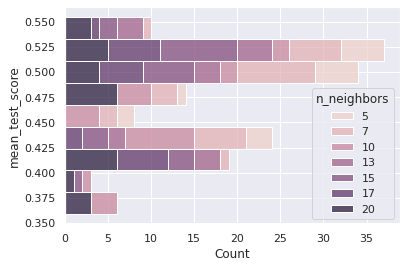

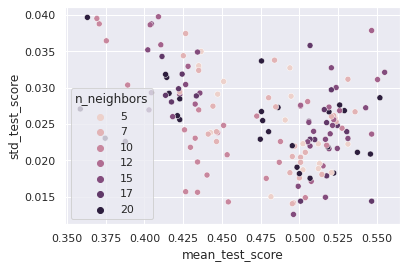

In [491]:
plot_mean_std(knn_results_df, "param_classifier__n_neighbors", "n_neighbors")

No geral, os melhores resultados utilizaram a padronização e k >= 13

In [492]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "n_neighbors"     : "param_classifier__n_neighbors"
, "minkowski-p"     : "param_classifier__p"
, "weights"         : "param_classifier__weights"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
}
knn_params_df = show_top_n(knn_results_df, 50, column_mapping)

mean_score  std_score n_neighbors minkowski-p   weights  \
105       0.555      0.032          15       1.000   uniform   
91        0.552      0.029          20       1.000  distance   
75        0.550      0.031          13       1.500   uniform   
123       0.547      0.014          17       1.500  distance   
68        0.547      0.038          13       2.000   uniform   
7         0.547      0.024          13       1.000  distance   
136       0.546      0.021          20       1.500  distance   
37        0.543      0.027          15       2.000   uniform   
181       0.537      0.021          20       1.500  distance   
67        0.536      0.027           7       2.000   uniform   
125       0.531      0.022           5       1.000   uniform   
63        0.531      0.031           7       2.000   uniform   
170       0.531      0.023          15       1.500  distance   
112       0.531      0.024          17       2.000   uniform   
190       0.529      0.027          20       1.500  distance   
85        0.528      0.024          10       1.500  distance   
2         0.526      0.027          13       1.500   uniform   
153       0.526      0.028          20       2.000  distance   
149       0.524      0.025          17       2.000  distance   
184       0.524      0.022          15       2.000  distance   
15        0.524      0.025           7       1.500  distance   
176       0.524      0.030          15       1.000  distance   
197       0.523      0.026           7       1.500   uniform   
129       0.522      0.026           7       2.000  distance   
143       0.522      0.018          20       1.500  distance   
147       0.522      0.026          13       2.000  distance   
183       0.521      0.025          15       2.000  distance   
162       0.521      0.018           5       1.000   uniform   
19        0.521      0.030          17       1.000   uniform   
139       0.521      0.026           7       2.000  distance   
160       0.521      0.033          15       1.000   uniform   
16        0.520      0.024          15       2.000  distance   
30        0.519      0.027          20       1.000   uniform   
42        0.519      0.022          15       1.000  distance   
178       0.519      0.027          13       2.000   uniform   
167       0.518      0.022          20       1.000  distance   
175       0.518      0.025          17       2.000  distance   
32        0.518      0.018          17       1.000  distance   
124       0.518      0.022          10       1.000  distance   
93        0.517      0.023          15       1.500  distance   
132       0.517      0.015          15       1.500  distance   
73        0.516      0.027          17       1.500   uniform   
134       0.515      0.019          13       2.000  distance   
119       0.515      0.018           7       1.000   uniform   
29        0.513      0.020           5       2.000  distance   
55        0.512      0.019           5       1.000  distance   
13        0.512      0.022           5       1.000   uniform   
48        0.510      0.023          17       1.500   uniform   
3         0.509      0.024          15       1.500   uniform   
187       0.508      0.017          13       2.000   uniform   

      feature_scaling           reduce_dim  
105  StandardScaler()          passthrough  
91   StandardScaler()          passthrough  
75   StandardScaler()          passthrough  
123  StandardScaler()          passthrough  
68   StandardScaler()          passthrough  
7    StandardScaler()          passthrough  
136  StandardScaler()          passthrough  
37   StandardScaler()          passthrough  
181    MinMaxScaler()          passthrough  
67   StandardScaler()  PCA(n_components=5)  
125  StandardScaler()          passthrough  
63   StandardScaler()          passthrough  
170    MinMaxScaler()          passthrough  
112  StandardScaler()  PCA(n_components=5)  
190    MinMaxScaler()  PCA(n_components=5)  
85   StandardScaler(

Segue abaixo as métricas apuradas para comparação posterior.

== Test accuracy score  :  0.7818267865593942 ===
== Test precision score :  0.6 ===
== Test recall score    :  0.5347593582887701 ===
== Test F1 Score        :  0.5655042412818096 ===
== Test ROC AUC         :  0.8163343945825754 ===


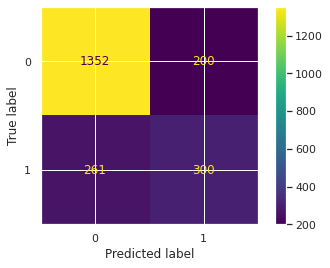

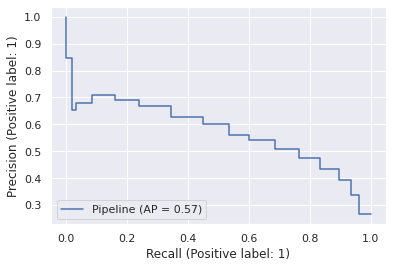

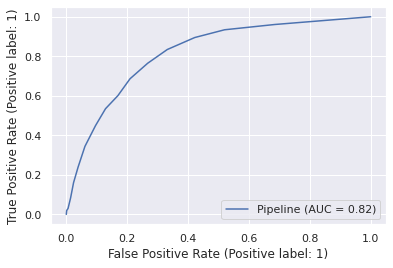

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1552
           1       0.60      0.53      0.57       561

    accuracy                           0.78      2113
   macro avg       0.72      0.70      0.71      2113
weighted avg       0.77      0.78      0.78      2113



In [493]:
report_results(knn_grid, "knn")

### 8. Naive Bayes

A grade abaixo contém as variações de hiperparâmetros que serão testados.

O algoritmo não possui muitos hiper parâmetros que possam ser testados.

In [494]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # GaussianNB
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [GaussianNB()],
    "classifier__var_smoothing"     : [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
  }  
]
if QUICK_RUN:
  nb_grid, nb_results_df =  search_hyperparameters(param_grid, 20, "nb")
else:  
  nb_grid, nb_results_df =  search_hyperparameters(param_grid, 200, "nb")

Melhor recall: 0.8027522935779817
Melhor estimador -> 


Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier', GaussianNB(var_smoothing=0.001))])

O melhor resultado obtido com o NaiveBayes foi um recall de 0.8027 com um desvio padrão de 0.02984 usando normalização e k=15


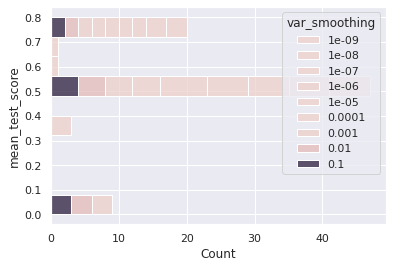

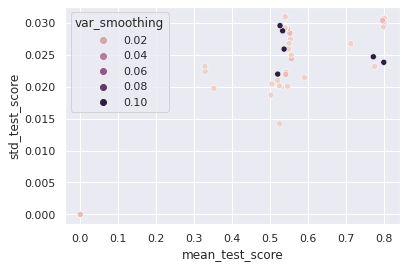

In [495]:
plot_mean_std(nb_results_df, "param_classifier__var_smoothing", "var_smoothing")

Os melhores resultados obtidos com o algoritmo NaiveBayes beneficiaram-se do uso de padronização ou normalização, assim como var_smoothing >= 0.01

In [496]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "var_smoothing"   : "param_classifier__var_smoothing"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
}
pd.set_option('display.float_format', lambda x: '%0.10f' % x)
nb_params_df = show_top_n(nb_results_df, 50, column_mapping)
pd.set_option('display.float_format', lambda x: '%0.3f' % x)

mean_score    std_score var_smoothing   feature_scaling  \
66 0.8027522936 0.0298459041  0.0100000000    MinMaxScaler()   
57 0.8027522936 0.0298459041  0.0010000000    MinMaxScaler()   
21 0.8019877676 0.0307050239  0.0000001000    MinMaxScaler()   
42 0.8019877676 0.0307050239  0.0000100000  StandardScaler()   
3  0.8019877676 0.0307050239  0.0000000010    MinMaxScaler()   
39 0.8019877676 0.0307050239  0.0000100000    MinMaxScaler()   
51 0.8019877676 0.0307050239  0.0001000000  StandardScaler()   
6  0.8019877676 0.0307050239  0.0000000010  StandardScaler()   
33 0.8019877676 0.0307050239  0.0000010000  StandardScaler()   
30 0.8019877676 0.0307050239  0.0000010000    MinMaxScaler()   
12 0.8019877676 0.0307050239  0.0000000100    MinMaxScaler()   
24 0.8019877676 0.0307050239  0.0000001000  StandardScaler()   
48 0.8019877676 0.0307050239  0.0001000000    MinMaxScaler()   
15 0.8019877676 0.0307050239  0.0000000100  StandardScaler()   
60 0.8012232416 0.0301576191  0.0010000000  StandardScaler()   
75 0.8004587156 0.0237987499  0.1000000000    MinMaxScaler()   
0  0.7996941896 0.0293323029  0.0000000010       passthrough   
69 0.7974006116 0.0303604429  0.0100000000  StandardScaler()   
9  0.7759938838 0.0231513822  0.0000000100       passthrough   
78 0.7729357798 0.0246670731  0.1000000000  StandardScaler()   
18 0.7133027523 0.0267146869  0.0000001000       passthrough   
27 0.5909785933 0.0214203757  0.0000010000       passthrough   
61 0.5565749235 0.0249380832  0.0010000000  StandardScaler()   
52 0.5565749235 0.0249380832  0.0001000000  StandardScaler()   
7  0.5565749235 0.0249380832  0.0000000010  StandardScaler()   
34 0.5565749235 0.0249380832  0.0000010000  StandardScaler()   
43 0.5565749235 0.0249380832  0.0000100000  StandardScaler()   
25 0.5565749235 0.0249380832  0.0000001000  StandardScaler()   
70 0.5565749235 0.0243690787  0.0100000000  StandardScaler()   
16 0.5565749235 0.0249380832  0.0000000100  StandardScaler()   
59 0.5542813456 0.0274485062  0.0010000000    MinMaxScaler()   
32 0.5542813456 0.0274485062  0.0000010000    MinMaxScaler()   
23 0.5542813456 0.0274485062  0.0000001000    MinMaxScaler()   
14 0.5542813456 0.0274485062  0.0000000100    MinMaxScaler()   
5  0.5542813456 0.0274485062  0.0000000010    MinMaxScaler()   
50 0.5542813456 0.0274485062  0.0001000000    MinMaxScaler()   
41 0.5542813456 0.0274485062  0.0000100000    MinMaxScaler()   
68 0.5527522936 0.0283699928  0.0100000000    MinMaxScaler()   
2  0.5504587156 0.0267474858  0.0000000010       passthrough   
11 0.5496941896 0.0258699149  0.0000000100       passthrough   
20 0.5466360856 0.0200678972  0.0000001000       passthrough   
71 0.5466360856 0.0290620456  0.0100000000  StandardScaler()   
58 0.5428134557 0.0222633330  0.0010000000    MinMaxScaler()   
49 0.5428134557 0.0222633330  0.0001000000    MinMaxScaler()   
40 0.5428134557 0.0222633330  0.0000100000    MinMaxScaler()   
22 0.5428134557 0.0222633330  0.0000001000    MinMaxScaler()   
13 0.5428134557 0.0222633330  0.0000000100    MinMaxScaler()   
4  0.5428134557 0.0222633330  0.0000000010    MinMaxScaler()   
31 0.5428134557 0.0222633330  0.0000010000    MinMaxScaler()   
67 0.5420489297 0.0219060379  0.0100000000    MinMaxScaler()   

             reduce_dim  
66          passthrough  
57          passthrough  
21          passthrough  
42          passthrough  
3           passthrough  
39          passthrough  
51          passthrough  
6           passthrough  
33          passthrough  
30          passthrough  
12          passthrough  
24          passthrough  
48          passthrough  
15          passthrough  
60          passthrough  
75          passthrough  
0           passthrough  
69          passthrough  
9           passthrough  
78          passthrough  
18          passthrough  
27          passthrough  
61  PCA(n_components=3)  
52  PCA(n_components=3)  
7   PCA(n_components=3)  
34  PCA(n_components=3)  
43  PCA(n_components=3)  
25  PCA(n_co

Segue abaixo as métricas apuradas para comparação posterior.

== Test accuracy score  :  0.7359204921911974 ===
== Test precision score :  0.5016759776536313 ===
== Test recall score    :  0.8003565062388592 ===
== Test F1 Score        :  0.6167582417582417 ===
== Test ROC AUC         :  0.8319631273315324 ===


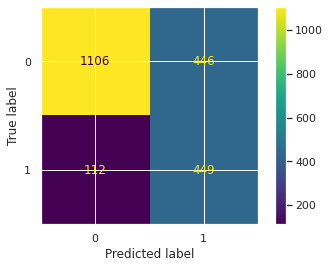

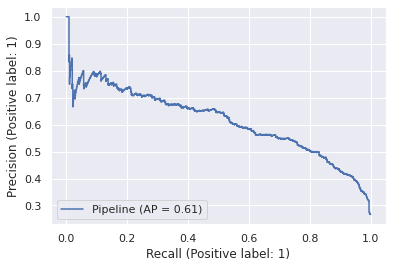

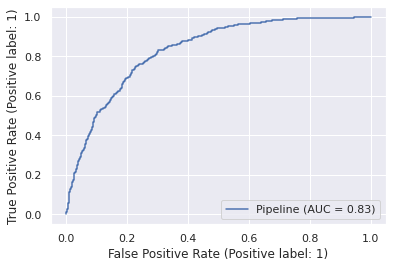

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1552
           1       0.50      0.80      0.62       561

    accuracy                           0.74      2113
   macro avg       0.70      0.76      0.71      2113
weighted avg       0.80      0.74      0.75      2113



In [497]:
report_results(nb_grid, "nb")

### 9. Árvore de Decisão

A grade abaixo contém as variações de hiperparâmetros que serão testados.

In [498]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # DecisionTreeClassifier
  {
    "feature_scaling__num__scaler"  : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [DecisionTreeClassifier()],
    "classifier__class_weight"      : [None, "balanced"],
    "classifier__criterion"         : ["gini", "entropy"],
    "classifier__splitter"          : ["best", "random"],
    "classifier__max_features"      : [None, "auto", "sqrt", "log2"],
  }  
]
if QUICK_RUN:
  dt_grid, dt_results_df =  search_hyperparameters(param_grid, 20, "dt")
else:
  dt_grid, dt_results_df =  search_hyperparameters(param_grid, 200, "dt")

Melhor recall: 0.5351681957186544
Melhor estimador -> 


Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier', DecisionTreeClassifier(max_features='log2'))])

O melhor resultado obtido com  Árvore de Decisão foi um recall de 0.5351 com um desvio padrão de 0.02 usando padronização, o critério de impureza gini e uso do melhor ponto de corte (splitter="best").


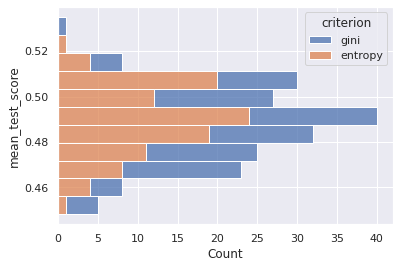

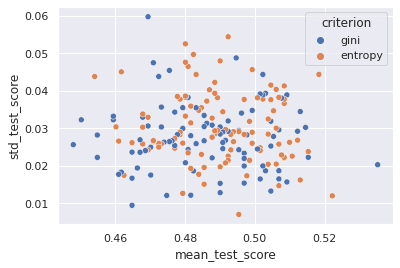

In [499]:
plot_mean_std(dt_results_df, "param_classifier__criterion", "criterion")

No geral a Árvore de Decisões comportou-se muito mal para este conjunto de dados e não conseguimos diagnosticar a causa.

Árvores de Decisão são famosas pela propensidade de se sobreajustarem ao conjunto de treino(overfitting). Acreditamos que seja isso o que tenha acontecido aqui, mas não tivemos tempo para diagnosticar isso.

O parâmetro **ccp_alpha** talvez pudesse ter sido explorado, pois ele é utilizado para realizar *prunning* da árvore de classificação resultante e, com isso, possivelmente poderia em teoria reduzir a variância do modelo.

In [500]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "class_weight"    : "param_classifier__class_weight"
, "criterion"       : "param_classifier__criterion"
, "splitter"        : "param_classifier__splitter"
, "max_features"    : "param_classifier__max_features"
}
dt_params_df = show_top_n(dt_results_df, 50, column_mapping)

mean_score  std_score   feature_scaling           reduce_dim  \
140       0.535      0.020  StandardScaler()          passthrough   
154       0.522      0.012    MinMaxScaler()          passthrough   
170       0.518      0.044       passthrough  PCA(n_components=5)   
28        0.515      0.022  StandardScaler()          passthrough   
134       0.515      0.024       passthrough  PCA(n_components=5)   
109       0.515      0.030       passthrough  PCA(n_components=5)   
121       0.513      0.016       passthrough  PCA(n_components=5)   
59        0.513      0.034  StandardScaler()          passthrough   
131       0.512      0.027    MinMaxScaler()          passthrough   
51        0.512      0.029       passthrough          passthrough   
190       0.511      0.023       passthrough          passthrough   
37        0.510      0.026    MinMaxScaler()  PCA(n_components=5)   
128       0.509      0.039  StandardScaler()          passthrough   
39        0.509      0.016    MinMaxScaler()          passthrough   
53        0.508      0.037  StandardScaler()          passthrough   
160       0.508      0.038  StandardScaler()          passthrough   
72        0.508      0.041  StandardScaler()          passthrough   
168       0.508      0.022       passthrough          passthrough   
58        0.508      0.022       passthrough  PCA(n_components=5)   
127       0.508      0.023       passthrough          passthrough   
162       0.508      0.038  StandardScaler()          passthrough   
182       0.507      0.030       passthrough  PCA(n_components=5)   
149       0.507      0.038       passthrough          passthrough   
25        0.507      0.016       passthrough  PCA(n_components=5)   
85        0.507      0.015       passthrough  PCA(n_components=5)   
83        0.507      0.026       passthrough  PCA(n_components=5)   
180       0.507      0.019       passthrough          passthrough   
189       0.506      0.040    MinMaxScaler()          passthrough   
137       0.506      0.020       passthrough  PCA(n_components=5)   
63        0.506      0.030  StandardScaler()          passthrough   
54        0.505      0.028       passthrough          passthrough   
104       0.505      0.035       passthrough          passthrough   
156       0.505      0.032    MinMaxScaler()          passthrough   
125       0.505      0.038       passthrough          passthrough   
18        0.505      0.013       passthrough          passthrough   
86        0.505      0.042       passthrough  PCA(n_components=5)   
135       0.505      0.025    MinMaxScaler()          passthrough   
81        0.504      0.020    MinMaxScaler()  PCA(n_components=3)   
179       0.504      0.028  StandardScaler()  PCA(n_components=5)   
35        0.504      0.032  StandardScaler()          passthrough   
5         0.503      0.039  StandardScaler()          passthrough   
120       0.503      0.019       passthrough  PCA(n_components=5)   
41        0.502      0.038    MinMaxScaler()          passthrough   
133       0.502      0.020  StandardScaler()          passthrough   
46        0.502      0.039       passthrough  PCA(n_components=5)   
198       0.502      0.044    MinMaxScaler()          passthrough   
45        0.502      0.025       passthrough  PCA(n_components=5)   
194       0.502      0.016    MinMaxScaler()          passthrough   
107       0.502      0.039       passthrough          passthrough   
113       0.502      0.024    MinMaxScaler()          passthrough   

    class_weight criterion splitter max_features  
140         None      gini     best         log2  
154         None   entropy   random         None  
170         None   entropy     best         None  
28          None      gini     best         sqrt  
134     balanced   entropy   random         auto  
109     balanced      gini   random         sqrt  
121         None   entropy     best         sqrt  
59          None      gini     best         None  
131         None   entropy

Segue abaixo as métricas apuradas para comparação posterior.

== Test accuracy score  :  0.7174633222905821 ===
== Test precision score :  0.4676258992805755 ===
== Test recall score    :  0.46345811051693403 ===
== Test F1 Score        :  0.4655326768128917 ===
== Test ROC AUC         :  0.636368230516199 ===


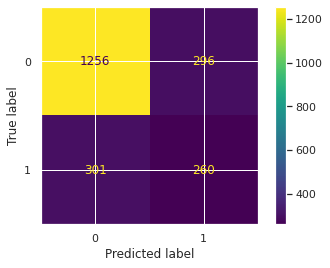

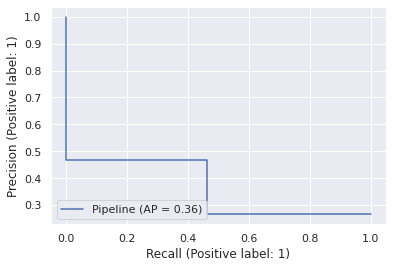

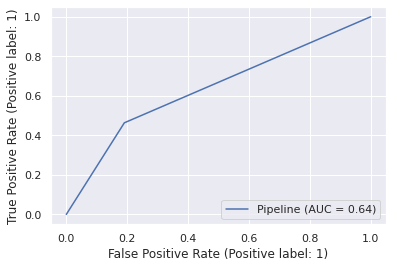

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1552
           1       0.47      0.46      0.47       561

    accuracy                           0.72      2113
   macro avg       0.64      0.64      0.64      2113
weighted avg       0.72      0.72      0.72      2113



In [501]:
report_results(dt_grid, "dt")

### 10. SVM

A grade abaixo contém as variações de hiperparâmetros que serão testados.

O SVM corre o risco de não convergir ou demorar desnecessariamente muito caso as variáveis não estejam escalonadas. Por esse motivo, todos os testes ou irão padronizar ou normalizar o conjunto de dados.

In [502]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # SVC
  {
    "feature_scaling__num__scaler"  : [MinMaxScaler(), StandardScaler()], # SVC precisa ter os argumentos escalonados para uma melhor performance
    "reduce_dim"                    : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                    : [SVC(probability=True)],
    "classifier__kernel"            : ["linear","rbf"],
    "classifier__gamma"             : ["scale", "auto"],
    "classifier__class_weight"      : ["balanced"],
  }  
]
if QUICK_RUN:
  svm_grid, svm_results_df =  search_hyperparameters(param_grid, 5, "svm")
else:  
  svm_grid, svm_results_df =  search_hyperparameters(param_grid, 50, "svm")

Melhor recall: 0.8860856269113149
Melhor estimador -> 


Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier',
                 SVC(class_weight='balanced', kernel='linear',
                     probability=True))])

O melhor resultado obtido com SVM foi um recall de 0.8860 com um desvio padrão de 0.014 usando normalização e o kernel linear.


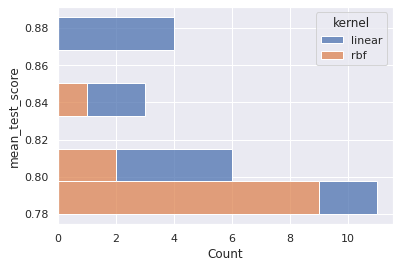

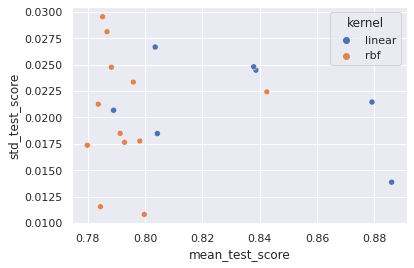

In [503]:
plot_mean_std(svm_results_df, "param_classifier__kernel", "kernel")

Observamos que o uso do kernel linear aparentou ser melhor para esse conjunto de dados.

PCA parece ter ajudado em alguns modelos bons. Uma alternativa que valeria ser explorada em outras oportunidades seria a concatenação das colunas resultantes da transformação PCA no conjunto de dados original. Isto não foi realizado por falta de tempo.

In [504]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "gamma"           : "param_classifier__gamma"
, "kernel"          : "param_classifier__kernel"
}
svm_params_df = show_top_n(svm_results_df, 50, column_mapping)

mean_score  std_score   feature_scaling           reduce_dim  gamma  \
0        0.886      0.014    MinMaxScaler()          passthrough  scale   
12       0.886      0.014    MinMaxScaler()          passthrough   auto   
15       0.879      0.021  StandardScaler()          passthrough   auto   
3        0.879      0.021  StandardScaler()          passthrough  scale   
18       0.843      0.022    MinMaxScaler()          passthrough   auto   
14       0.839      0.024    MinMaxScaler()  PCA(n_components=5)   auto   
2        0.838      0.025    MinMaxScaler()  PCA(n_components=5)  scale   
1        0.804      0.018    MinMaxScaler()  PCA(n_components=3)  scale   
13       0.804      0.018    MinMaxScaler()  PCA(n_components=3)   auto   
16       0.804      0.027  StandardScaler()  PCA(n_components=3)   auto   
4        0.804      0.027  StandardScaler()  PCA(n_components=3)  scale   
20       0.800      0.011    MinMaxScaler()  PCA(n_components=5)   auto   
7        0.798      0.018    MinMaxScaler()  PCA(n_components=3)  scale   
21       0.796      0.023  StandardScaler()          passthrough   auto   
19       0.793      0.018    MinMaxScaler()  PCA(n_components=3)   auto   
10       0.791      0.018  StandardScaler()  PCA(n_components=3)  scale   
5        0.789      0.021  StandardScaler()  PCA(n_components=5)  scale   
17       0.789      0.021  StandardScaler()  PCA(n_components=5)   auto   
9        0.788      0.025  StandardScaler()          passthrough  scale   
11       0.787      0.028  StandardScaler()  PCA(n_components=5)  scale   
23       0.785      0.030  StandardScaler()  PCA(n_components=5)   auto   
8        0.784      0.012    MinMaxScaler()  PCA(n_components=5)  scale   
22       0.784      0.021  StandardScaler()  PCA(n_components=3)   auto   
6        0.780      0.017    MinMaxScaler()          passthrough  scale   

    kernel  
0   linear  
12  linear  
15  linear  
3   linear  
18     rbf  
14  linear  
2   linear  
1   linear  
13  linear  
16  linear  
4   linear  
20     rbf  
7      rbf  
21     rbf  
19     rbf  
10     rbf  
5   linear  
17  linear  
9      rbf  
11     rbf  
23     rbf  
8      rbf  
22     rbf  
6      rbf

Segue abaixo as métricas apuradas para comparação posterior.

== Test accuracy score  :  0.6497870326549929 ===
== Test precision score :  0.42356959863364646 ===
== Test recall score    :  0.8841354723707665 ===
== Test F1 Score        :  0.5727482678983834 ===
== Test ROC AUC         :  0.8316243085800393 ===


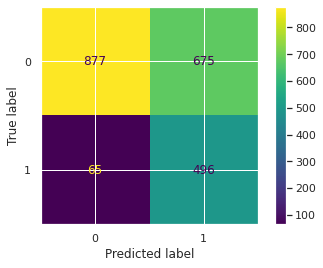

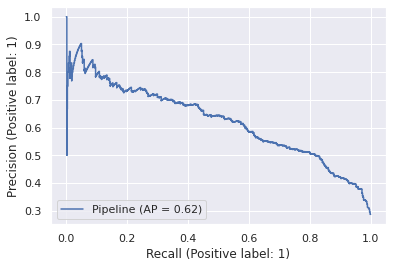

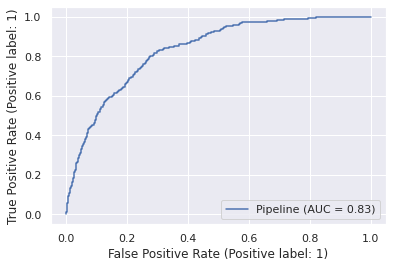

              precision    recall  f1-score   support

           0       0.93      0.57      0.70      1552
           1       0.42      0.88      0.57       561

    accuracy                           0.65      2113
   macro avg       0.68      0.72      0.64      2113
weighted avg       0.80      0.65      0.67      2113



In [505]:
report_results(svm_grid, "svm")

### 11. AdaBoost

A grade abaixo contém as variações de hiperparâmetros que serão testados.

In [506]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # AdaBoostClassifier
  {
    "feature_scaling__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                      : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                      : [AdaBoostClassifier()],
    "classifier__n_estimators"        : [25, 50, 75, 100],
    "classifier__learning_rate"       : [0.001, 0.01, 0.1, 1.0]
  }  
]
if QUICK_RUN:
  ada_grid, ada_results_df =  search_hyperparameters(param_grid, 5, "ada")
else:  
  ada_grid, ada_results_df =  search_hyperparameters(param_grid, 64, "ada")

Melhor recall: 0.7010703363914373
Melhor estimador -> 


Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier',
                 AdaBoostClassifier(learning_rate=0.001, n_estimators=75))])

O melhor resultado obtido com AdaBoost foi um recall de 0.701 com um desvio padrão de 0.038. Os modelos se beneficiaram de uma taxa de aprendizagem baixa, por volta de 0.001.

Idealmente deveríamos explorar melhor esse parâmetro numa segunda rodada de treino, mas não tivemos tempo.

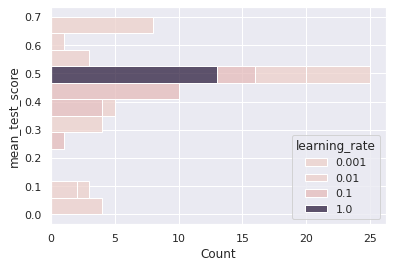

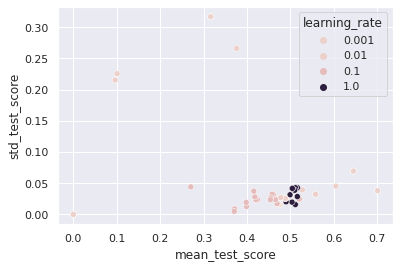

In [507]:
plot_mean_std(ada_results_df, "param_classifier__learning_rate", "learning_rate")

In [508]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "n_estimators"    : "param_classifier__n_estimators"
, "learning_rate"   : "param_classifier__learning_rate"
}
ada_params_df = show_top_n(ada_results_df, 50, column_mapping)

mean_score  std_score   feature_scaling           reduce_dim n_estimators  \
0        0.701      0.038    MinMaxScaler()          passthrough           75   
36       0.701      0.038  StandardScaler()          passthrough           50   
51       0.701      0.038  StandardScaler()          passthrough           75   
27       0.701      0.038    MinMaxScaler()          passthrough           50   
47       0.645      0.070  StandardScaler()  PCA(n_components=3)          100   
18       0.645      0.070  StandardScaler()  PCA(n_components=3)           25   
17       0.645      0.070  StandardScaler()  PCA(n_components=3)           50   
50       0.645      0.070  StandardScaler()  PCA(n_components=3)           75   
44       0.605      0.045  StandardScaler()  PCA(n_components=5)           25   
3        0.558      0.032  StandardScaler()  PCA(n_components=5)           50   
15       0.558      0.032  StandardScaler()  PCA(n_components=3)           50   
7        0.528      0.039  StandardScaler()  PCA(n_components=5)           75   
5        0.521      0.025    MinMaxScaler()          passthrough          100   
54       0.516      0.043    MinMaxScaler()          passthrough          100   
28       0.516      0.043       passthrough          passthrough          100   
34       0.516      0.043  StandardScaler()          passthrough          100   
12       0.516      0.029  StandardScaler()  PCA(n_components=3)           25   
10       0.511      0.043       passthrough          passthrough           50   
25       0.511      0.043    MinMaxScaler()          passthrough           50   
48       0.511      0.016  StandardScaler()  PCA(n_components=5)           25   
45       0.510      0.039    MinMaxScaler()          passthrough           25   
16       0.505      0.042    MinMaxScaler()          passthrough           75   
59       0.505      0.042       passthrough          passthrough           75   
19       0.504      0.020  StandardScaler()  PCA(n_components=3)           75   
62       0.499      0.030       passthrough  PCA(n_components=5)           25   
37       0.499      0.030       passthrough  PCA(n_components=3)           25   
22       0.499      0.031    MinMaxScaler()  PCA(n_components=3)           25   
56       0.490      0.020       passthrough  PCA(n_components=3)           75   
55       0.489      0.026       passthrough  PCA(n_components=5)           75   
31       0.489      0.026       passthrough  PCA(n_components=3)           50   
41       0.489      0.026       passthrough  PCA(n_components=3)           75   
21       0.478      0.027  StandardScaler()  PCA(n_components=5)          100   
4        0.476      0.016       passthrough  PCA(n_components=3)           50   
42       0.474      0.016       passthrough  PCA(n_components=3)           75   
2        0.472      0.017       passthrough  PCA(n_components=5)          100   
11       0.469      0.017    MinMaxScaler()          passthrough           50   
35       0.469      0.017  StandardScaler()          passthrough           50   
38       0.466      0.024  StandardScaler()  PCA(n_components=5)           25   
63       0.461      0.032  StandardScaler()  PCA(n_components=3)           75   
52       0.458      0.033    MinMaxScaler()  PCA(n_components=3)          100   
33       0.455      0.027  StandardScaler()  PCA(n_components=3)           50   
57       0.454      0.024       passthrough  PCA(n_components=5)          100   
1        0.424      0.024    MinMaxScaler()  PCA(n_components=3)           75   
39       0.420      0.024       passthrough  PCA(n_components=5)           75   
14       0.418      0.028    MinMaxScaler()  PCA(n_components=5)           75   
29       0.416      0.037  StandardScaler()          passthrough           25   
46       0.416      0.037       passthrough          passthrough           25   
32       0.399      0.013       passthrough  PCA(n_components=5)           50   
60       0.398      0.019       pas

Segue abaixo as métricas apuradas para comparação posterior.

== Test accuracy score  :  0.7283483199242783 ===
== Test precision score :  0.4915254237288136 ===
== Test recall score    :  0.6720142602495544 ===
== Test F1 Score        :  0.5677710843373495 ===
== Test ROC AUC         :  0.7103628002278699 ===


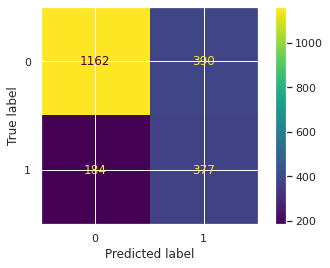

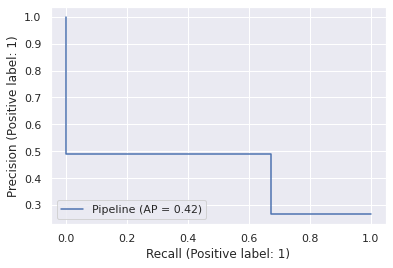

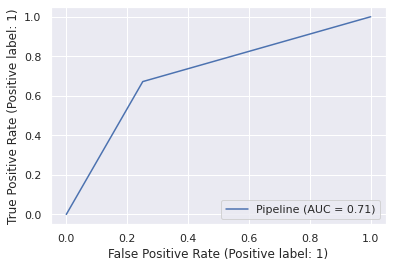

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1552
           1       0.49      0.67      0.57       561

    accuracy                           0.73      2113
   macro avg       0.68      0.71      0.68      2113
weighted avg       0.76      0.73      0.74      2113



In [509]:
report_results(ada_grid, "ada")

### 12. GradientBoosting

A grade abaixo contém as variações de hiperparâmetros que serão testados.

In [510]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # GradientBoostingClassifier
  {
    "feature_scaling__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                      : ["passthrough", PCA(n_components=3), PCA(n_components=5)],
    "classifier"                      : [GradientBoostingClassifier()],
    "classifier__loss"                : ["log_loss", "deviance", "exponential"],
    "classifier__n_estimators"        : [50, 75, 100, 150],
    "classifier__learning_rate"       : [0.1, 0.3, 0.5, 0.7, 1.0],
    "classifier__max_depth"           : [3, 5, 10],
    "classifier__max_features"        : [None, "sqrt", "log2"]
  }  
]
if QUICK_RUN:
  gb_grid, gb_results_df =  search_hyperparameters(param_grid, 10, "gb")
else:  
  gb_grid, gb_results_df =  search_hyperparameters(param_grid, 100, "gb")

Melhor recall: 0.5229357798165137
Melhor estimador -> 


Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', PCA(n_components=5)),
                ('classifier',
                 GradientBoostingClassifier(max_features='sqrt',
                                            n_estimators=150))])

O melhor resultado obtido com GradientBoosting foi um recall de 0.5229 com um desvio padrão de 0.025. Os modelos se beneficiaram de uma taxa de aprendizagem baixa, por volta de 0.001.


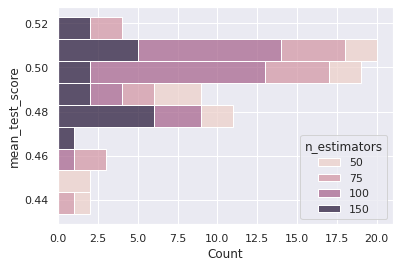

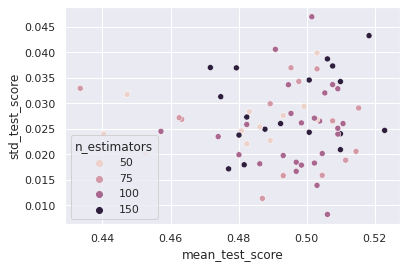

In [511]:
plot_mean_std(gb_results_df, "param_classifier__n_estimators", "n_estimators")

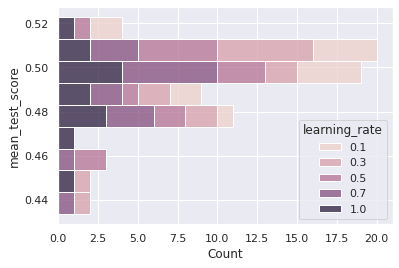

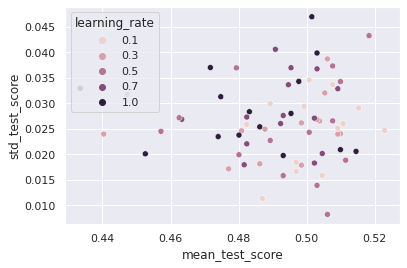

In [512]:
plot_mean_std(gb_results_df, "param_classifier__learning_rate", "learning_rate")

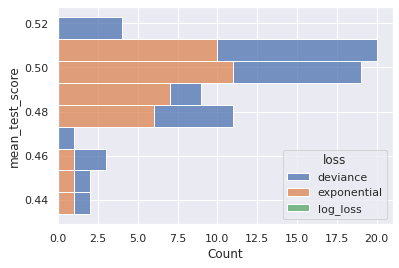

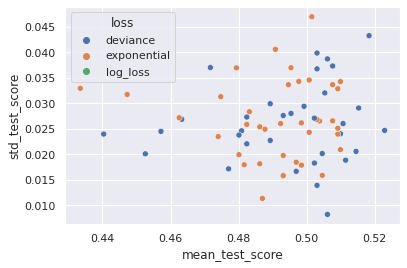

In [513]:
plot_mean_std(gb_results_df, "param_classifier__loss", "loss")

Os melhores modelos parecem terem se beneficiado do uso da função de perda *deviance* e o uso de PCA com 5 componentes parece ter ajudado no resultado dos melhores modelos.

In [514]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "loss"            : "param_classifier__loss"
, "n_estimators"    : "param_classifier__n_estimators"
, "loss"            : "param_classifier__loss"
, "learning_rate"   : "param_classifier__learning_rate"
, "max_depth"       : "param_classifier__max_depth"
, "max_features"    : "param_classifier__max_features"
}
gb_params_df = show_top_n(gb_results_df, 50, column_mapping)

mean_score  std_score   feature_scaling           reduce_dim         loss  \
47       0.523      0.025  StandardScaler()  PCA(n_components=5)     deviance   
95       0.518      0.043       passthrough          passthrough     deviance   
30       0.515      0.029       passthrough          passthrough     deviance   
90       0.515      0.021    MinMaxScaler()  PCA(n_components=5)     deviance   
31       0.511      0.019    MinMaxScaler()  PCA(n_components=5)     deviance   
59       0.511      0.026       passthrough          passthrough     deviance   
2        0.510      0.021       passthrough  PCA(n_components=5)  exponential   
9        0.510      0.024       passthrough          passthrough     deviance   
66       0.510      0.034       passthrough  PCA(n_components=5)  exponential   
40       0.509      0.024  StandardScaler()          passthrough  exponential   
37       0.509      0.033    MinMaxScaler()          passthrough  exponential   
34       0.509      0.025  StandardScaler()  PCA(n_components=5)  exponential   
96       0.508      0.034       passthrough  PCA(n_components=5)  exponential   
57       0.508      0.027       passthrough          passthrough  exponential   
25       0.508      0.037    MinMaxScaler()          passthrough     deviance   
45       0.506      0.039       passthrough          passthrough     deviance   
1        0.506      0.008  StandardScaler()          passthrough     deviance   
7        0.505      0.032  StandardScaler()  PCA(n_components=5)     deviance   
79       0.505      0.016       passthrough  PCA(n_components=5)  exponential   
26       0.505      0.020  StandardScaler()          passthrough     deviance   
20       0.504      0.027       passthrough          passthrough  exponential   
89       0.503      0.040       passthrough          passthrough     deviance   
67       0.503      0.027       passthrough          passthrough  exponential   
49       0.503      0.037       passthrough  PCA(n_components=5)     deviance   
19       0.503      0.014       passthrough  PCA(n_components=5)     deviance   
85       0.502      0.027  StandardScaler()          passthrough     deviance   
46       0.502      0.018    MinMaxScaler()  PCA(n_components=5)     deviance   
58       0.502      0.047    MinMaxScaler()          passthrough  exponential   
8        0.501      0.035       passthrough  PCA(n_components=5)  exponential   
16       0.501      0.024       passthrough          passthrough  exponential   
82       0.499      0.029  StandardScaler()  PCA(n_components=5)     deviance   
74       0.498      0.026  StandardScaler()  PCA(n_components=3)  exponential   
13       0.498      0.018    MinMaxScaler()  PCA(n_components=3)  exponential   
22       0.498      0.034  StandardScaler()          passthrough  exponential   
75       0.497      0.017    MinMaxScaler()  PCA(n_components=3)     deviance   
71       0.497      0.018    MinMaxScaler()  PCA(n_components=3)  exponential   
38       0.495      0.037  StandardScaler()  PCA(n_components=5)  exponential   
10       0.495      0.028    MinMaxScaler()  PCA(n_components=5)     deviance   
23       0.495      0.034       passthrough  PCA(n_components=5)  exponential   
77       0.493      0.028    MinMaxScaler()          passthrough     deviance   
63       0.493      0.016    MinMaxScaler()  PCA(n_components=5)     deviance   
88       0.493      0.020    MinMaxScaler()  PCA(n_components=5)  exponential   
51       0.493      0.016    MinMaxScaler()  PCA(n_components=3)  exponential   
68       0.492      0.026    MinMaxScaler()          passthrough  exponential   
81       0.491      0.041       passthrough  PCA(n_components=5)  exponential   
15       0.489      0.023    MinMaxScaler()  PCA(n_components=5)     deviance   
93       0.489      0.030  StandardScaler()  PCA(n_components=5)     deviance   
78       0.488      0.025    MinMaxScaler()  PCA(n_components=3)  exponential   
24       0.487      0.011    MinMax

Segue abaixo as métricas apuradas para comparação posterior.

== Test accuracy score  :  0.7946048272598202 ===
== Test precision score :  0.6439909297052154 ===
== Test recall score    :  0.5062388591800356 ===
== Test F1 Score        :  0.5668662674650699 ===
== Test ROC AUC         :  0.8376696390833747 ===


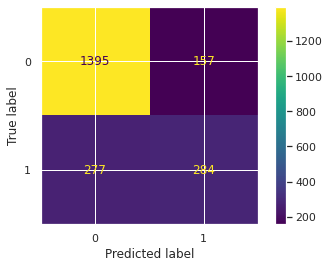

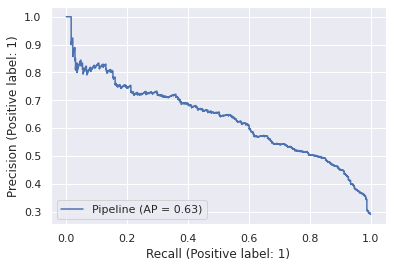

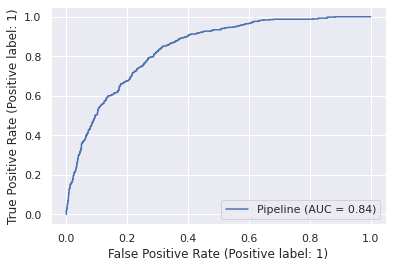

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1552
           1       0.64      0.51      0.57       561

    accuracy                           0.79      2113
   macro avg       0.74      0.70      0.72      2113
weighted avg       0.78      0.79      0.79      2113



In [515]:
report_results(gb_grid, "gb")

### 13. RandomForest

A grade abaixo contém as variações de hiperparâmetros que serão testados.

In [516]:
# Realiza a busca por hiperparâmetros
param_grid = [
  # RandomForestClassifier
  {
    "feature_scaling__num__scaler"    : ["passthrough", MinMaxScaler(), StandardScaler()],
    "reduce_dim"                      : ["passthrough"], #PCA(n_components=5), PCA(n_components=10)],
    "classifier"                      : [RandomForestClassifier()],
    "classifier__n_estimators"        : [50, 100, 150],
    "classifier__criterion"           : ["gini", "entropy"],
    "classifier__bootstrap"           : [True, False],
    "classifier__n_jobs"              : [-1],
    "classifier__class_weight"        : ["balanced", "balanced_subsample"],
  }
]
if QUICK_RUN:
  rf_grid, rf_results_df =  search_hyperparameters(param_grid, 10, "rf")
else:
  rf_grid, rf_results_df =  search_hyperparameters(param_grid, 100, "rf")

Melhor recall: 0.5
Melhor estimador -> 


Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', n_estimators=150,
                                        n_jobs=-1))])

O melhor resultado obtido com RandomForest foi um recall de 0.029 com um desvio padrão de 0.025.


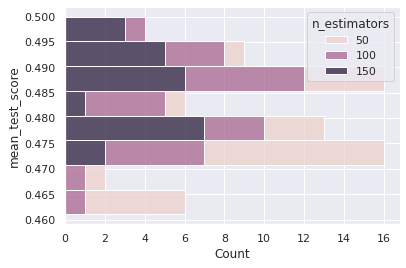

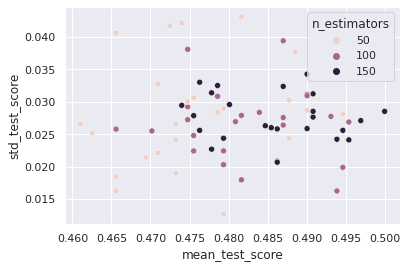

In [517]:
plot_mean_std(rf_results_df, "param_classifier__n_estimators", "n_estimators")

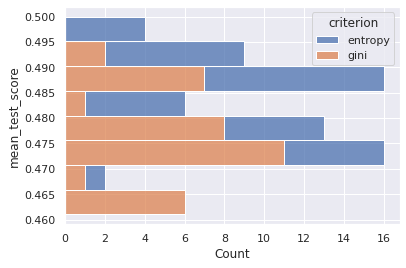

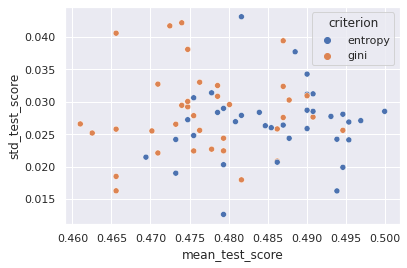

In [518]:
plot_mean_std(rf_results_df, "param_classifier__criterion", "criterion")

Os modelos parecem terem se beneficiados do critério de entropia assim como um número elevado de estimadores

In [519]:
column_mapping = {
  "mean_score"      : "mean_test_score"
, "std_score"       : "std_test_score"
, "feature_scaling" : "param_feature_scaling__num__scaler"
, "reduce_dim"      : "param_reduce_dim"
, "n_estimators"    : "param_classifier__n_estimators"
, "criterion"       : "param_classifier__criterion"
, "bootstrap"       : "param_classifier__bootstrap"
, "class_weight"    : "param_classifier__class_weight"
}
rf_params_df = show_top_n(rf_results_df, 50, column_mapping)

mean_score  std_score   feature_scaling   reduce_dim n_estimators  \
34       0.500      0.029    MinMaxScaler()  passthrough          150   
15       0.497      0.027       passthrough  passthrough          150   
51       0.495      0.024       passthrough  passthrough          150   
49       0.495      0.027    MinMaxScaler()  passthrough          100   
31       0.495      0.020    MinMaxScaler()  passthrough          100   
28       0.495      0.028    MinMaxScaler()  passthrough           50   
8        0.495      0.026  StandardScaler()  passthrough          150   
71       0.494      0.024  StandardScaler()  passthrough          150   
14       0.494      0.016  StandardScaler()  passthrough          100   
32       0.493      0.028  StandardScaler()  passthrough          100   
17       0.491      0.031  StandardScaler()  passthrough          150   
24       0.491      0.028       passthrough  passthrough          150   
35       0.491      0.029  StandardScaler()  passthrough          150   
12       0.490      0.031       passthrough  passthrough          100   
33       0.490      0.034       passthrough  passthrough          150   
3        0.490      0.031       passthrough  passthrough          100   
16       0.490      0.026    MinMaxScaler()  passthrough          150   
27       0.490      0.029       passthrough  passthrough           50   
11       0.489      0.038  StandardScaler()  passthrough           50   
0        0.488      0.030       passthrough  passthrough           50   
45       0.488      0.024       passthrough  passthrough           50   
22       0.487      0.028    MinMaxScaler()  passthrough          100   
26       0.487      0.032  StandardScaler()  passthrough          150   
13       0.487      0.026    MinMaxScaler()  passthrough          100   
21       0.487      0.039       passthrough  passthrough          100   
4        0.486      0.021    MinMaxScaler()  passthrough          100   
52       0.486      0.021    MinMaxScaler()  passthrough          150   
7        0.486      0.026    MinMaxScaler()  passthrough          150   
53       0.485      0.026  StandardScaler()  passthrough          150   
69       0.485      0.026       passthrough  passthrough          150   
68       0.484      0.028  StandardScaler()  passthrough          100   
5        0.482      0.018  StandardScaler()  passthrough          100   
30       0.482      0.028       passthrough  passthrough          100   
10       0.482      0.043    MinMaxScaler()  passthrough           50   
66       0.481      0.027       passthrough  passthrough          100   
60       0.480      0.030       passthrough  passthrough          150   
65       0.479      0.029  StandardScaler()  passthrough           50   
44       0.479      0.024  StandardScaler()  passthrough          150   
46       0.479      0.013    MinMaxScaler()  passthrough           50   
57       0.479      0.022       passthrough  passthrough          100   
48       0.479      0.020       passthrough  passthrough          100   
29       0.479      0.028  StandardScaler()  passthrough           50   
42       0.479      0.033       passthrough  passthrough          150   
40       0.479      0.031    MinMaxScaler()  passthrough          100   
6        0.478      0.023       passthrough  passthrough          150   
70       0.478      0.031    MinMaxScaler()  passthrough          150   
62       0.476      0.026  StandardScaler()  passthrough          150   
25       0.476      0.033    MinMaxScaler()  passthrough          150   
9        0.476      0.031       passthrough  passthrough           50   
43       0.476      0.028    MinMaxScaler()  passthrough          150   

   criterion bootstrap        class_weight  
34   entropy      True  balanced_subsample  
15   entropy      True            balanced  
51   entropy     False            balanced  
49   entropy     False            balanced  
31   entropy      True  balanced_subsample  
28   entro

Segue abaixo as métricas apuradas para comparação posterior.

== Test accuracy score  :  0.795551348793185 ===
== Test precision score :  0.655421686746988 ===
== Test recall score    :  0.48484848484848486 ===
== Test F1 Score        :  0.5573770491803278 ===
== Test ROC AUC         :  0.8269319560063952 ===


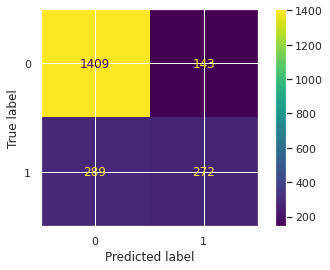

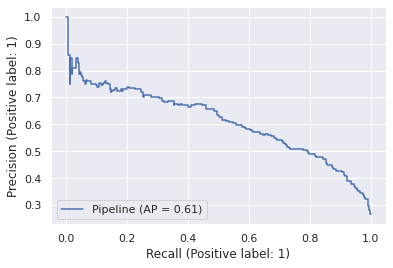

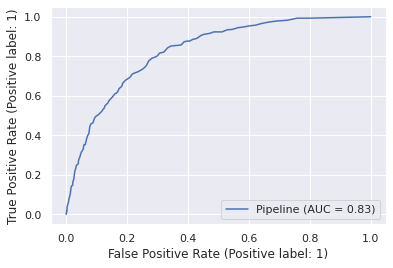

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1552
           1       0.66      0.48      0.56       561

    accuracy                           0.80      2113
   macro avg       0.74      0.70      0.71      2113
weighted avg       0.78      0.80      0.78      2113



In [520]:
report_results(rf_grid, "rf")

### 13. Ensemble de Votação com os estimadores anteriores

Por último, vamos criar um ensemble de estimadores já treinados utilizando votação soft, ou seja, ganha o modelo que está mais "confiante" em sua predição.

Este tipo votação é adequado somente em caso de estimadores bem calibrados, o que esperamos que seja o nosso caso depois de todo esse trabalho.

A versão da biblioteca scikit-learn instalada no colab não nos permite utilizar o estimador ensemble de votação sem treinar os estimadores subjacentes. Por esse motivo estamos uasndo o classificador **EnsembleVoteClassifier** da biblioteca **mlxtend**.

Um ponto negativo disso é que a busca no espaço de hiperparâmetros não funciona usando a classe **RandomizedSearchCV**. Foi preciso fazer a busca manualmente.

Para o caso do classificador **EnsembleVoteClassifier**, estamos buscando a combinação dos melhores classificadores anteioremente treinados que tenha o maior recall e, esperamos, que reduza a variância também.

A combinação de estimadores escolhidos foi:

- regressão logística
- Naive Bayes
- SVM (com kernel linear)

É curioso constatar que classificares considerados simples tenham se saído melhores que classificadores considerados mais robustos como GradientBoosting e RandomForests

In [521]:
from itertools import combinations

model_settings = MODEL_SETTINGS["vt"]

def compute_score(estimator):
  y_test_hat          = estimator.predict(X_test_df)
  train_score         = recall_score(y_test, y_test_hat)
  return train_score

if not model_settings["train"]:
    with open(model_settings["model_file"], "rb") as fh:
      classifier = pickle.load(fh)
else:
  # Realiza a busca por hiperparâmetros
  estimators_weights = [
      ( logreg_grid.best_estimator_,  logreg_grid.best_score_ )
  ,   ( knn_grid.best_estimator_,     knn_grid.best_score_    )
  ,   ( nb_grid.best_estimator_,      nb_grid.best_score_     )
  ,   ( svm_grid.best_estimator_,     svm_grid.best_score_    )
  ,   ( ada_grid.best_estimator_,     ada_grid.best_score_    )
  ,   ( gb_grid.best_estimator_,      gb_grid.best_score_     )
  ,   ( rf_grid.best_estimator_,      rf_grid.best_score_     )
  ]

  best_score      = -99999
  best_estimators = None
  best_type       = None

  for voting_type in ["soft"]:
    for i in [3, 4, 5, 6, 7]:
      for comb_estimators_weights in combinations(estimators_weights, i):
        # https://stackoverflow.com/questions/13635032/what-is-the-inverse-function-of-zip-in-python
        comb_estimators, weights = zip(*comb_estimators_weights)
        classifier = EnsembleVoteClassifier(clfs=comb_estimators, weights=weights, voting=voting_type, refit=False)  
        classifier.fit(None, y_train_df)
        score = compute_score(classifier)
        if score > best_score:
          best_score      = score
          best_estimators = comb_estimators_weights
          best_type       = voting_type

  comb_estimators, weights = zip(*best_estimators)
  classifier = EnsembleVoteClassifier(clfs=comb_estimators, weights=weights, voting=best_type, refit=False)    
  classifier.fit(None, y_train_df)
  with open(model_settings["model_file"], "wb") as fh:
    pickle.dump(classifier, fh)
  
print(f"best combination of estimators: {classifier.clfs}")
print(f"estimators weights: {classifier.weights}")
print(f"voting type: {classifier.voting}")


best combination of estimators: (Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   'passthrough')]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    penalty='none'))]), Pipeline(steps=[(

Segue abaixo as métricas apuradas para comparação posterior.

== Test accuracy score  :  0.7453857075248462 ===
== Test precision score :  0.5132641291810842 ===
== Test recall score    :  0.7932263814616756 ===
== Test F1 Score        :  0.623249299719888 ===
== Test ROC AUC         :  0.8351847768160685 ===


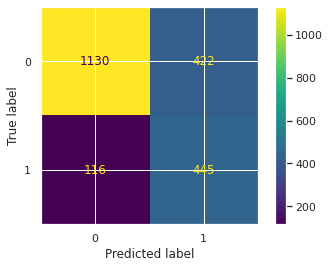

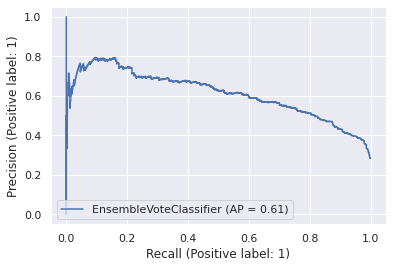

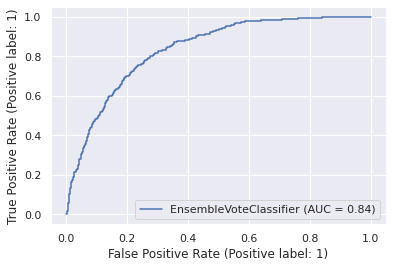

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1552
           1       0.51      0.79      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113



In [522]:
class PseudoGrid:
  def __init__(self, estimator):
      self.best_estimator_ = estimator
grid = PseudoGrid(classifier)
report_results(grid, "vt")

### 14. Comparação dos modelos

Para escolha do modelo final, vamos analisar a métrica F1 score, a média harmônica da precisão e do recall.

Esta métrica tende a otimizar o relacionamento entre precisão e recall penalizando modelos que apresentam uma performance muito ruim/baixa em qualquer uma das métricas individualmente.

Utilizando esse critério, o melhor modelo é a regressão logística. Averigua-se que o recall apurado por esse modelo é o segundo maior encontrado

In [523]:
records = list(RESULTS.values())
global_results_df = pd.DataFrame.from_records(records, columns=RESULT_COLUMNS, index="algoritmo")
global_results_df.sort_values("F1", ascending=False, inplace=True)
pd.set_option('display.float_format', lambda x: '%0.5f' % x)
display(global_results_df)
pd.set_option('display.float_format', lambda x: '%0.2f' % x)

acurácia  precisão  recall      F1  ROC AUC
algoritmo                                                        
Voting Ensemble        0.74539   0.51326 0.79323 0.62325  0.83518
Gaussian Naive Bayes   0.73592   0.50168 0.80036 0.61676  0.83196
Regressão Logística    0.72882   0.49349 0.81105 0.61362  0.83460
SVM                    0.64979   0.42357 0.88414 0.57275  0.83162
AdaBoost               0.72835   0.49153 0.67201 0.56777  0.71036
GradientBoosting       0.79460   0.64399 0.50624 0.56687  0.83767
K-Nearest Neighbors    0.78183   0.60000 0.53476 0.56550  0.81633
RandomForest           0.79555   0.65542 0.48485 0.55738  0.82693
Árvore de Decisão      0.71746   0.46763 0.46346 0.46553  0.63637

In [524]:
model = logreg_grid.best_estimator_
model

Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   'passthrough')]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    penalty='none'))])

### 15. Treinando o modelo escolhido com todo conjunto de dados


Para escolha do modelo final, vamos analisar a métrica F1 score, a média harmônica da precisão e do recall.

Esta métrica tende a otimizar o relacionamento entre precisão e recall penalizando modelos que apresentam uma performance muito ruim/baixa em qualquer uma das métricas individualmente.

Utilizando esse critério, o melhor modelo é a regressão logística. Averigua-se que o recall apurado por esse modelo é o segundo maior encontrado

In [525]:
model.fit(X_df, y)
display(model)

Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   'passthrough')]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges',
                                                   'client_factor',
                                                   'internet_factor',
                                                   'financial_factor',
                                                   'multi_factor'])])),
                ('reduce_dim', 'passthrough'),
                ('classifier',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    penalty='none'))])

Os coeficientes da regressão logísitica podem ser exibidos para identificar os fatores considerados mais e menos importantes para o processo de classificação

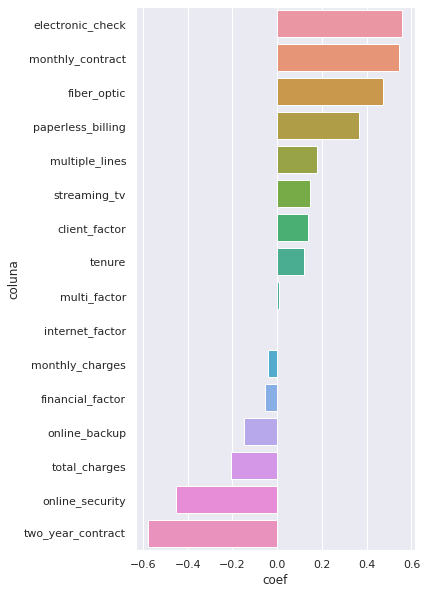

In [526]:
coefs_df = pd.DataFrame({
  'coef': model['classifier'].coef_.flatten()
,  'coluna': X_df.columns  
}, index=X_df.columns).sort_values('coef', ascending=False)

f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data=coefs_df
,   y="coluna"    
,   x="coef"
)



### 16. Persistência do modelo treinado


In [527]:
  with open(FINAL_MODEL, "wb") as fh:
    pickle.dump(model, fh)

## Resumo

**!!!FALTA FAZER!!!**

Resumidamente, neste exemplo trabalhamos com um problema de classificação binária de ponta a ponta. As etapas abordadas foram:
* Definição do problema (Pima Indians Diabetes).
* Carga dos dados
* Análise  e tratamento dos dados (verificamos que estavam na mesma escala, mas com diferentes distribuições de dados e possíves missings).
* Avaliação de modelos de linha base, considerando o dataset original e com tratamento de missings.
* Avaliação de modelos com normalização e padronização dos dados.
* Ajuste dos modelos, buscando melhorar o KNN e o SVM.
* Finalização do modelo (use todos os dados de treinamento e valide usando o conjunto de dados de teste).

É importante ressaltar que este exemplo não buscou ser exaustivo, apresentando apenas uma parte dos muitos recursos disponíveis na biblioteca Scikit-Learn. Poderíamos ter testado outras operações de pré-processamento de dados (como feature selection), outros valores de hiperparâmetros e ainda, outros modelos de classificação. Recomendamos que você explore a documentação disponível e incremente este notebook com novas possibilidades.

## Para saber mais:
* Statistical Significance Tests for Comparing Machine Learning Algorithms: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
* Hypothesis Test for Comparing Machine Learning Algorithms: https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/
* How to Calculate Parametric Statistical Hypothesis Tests in Python: https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/
* How to Use Statistical Significance Tests to Interpret Machine Learning Results: https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/
* 17 Statistical Hypothesis Tests in Python (Cheat Sheet): https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
